# **Modelo original**

El modelo original propuesto en este proyecto se basa en la implementación del enfoque de **pronóstico de velocidad del viento a corto plazo utilizando un modelo de ensamblaje apilado (stacking ensemble)**, tal como se describe en el trabajo de **Very Short-Term Wind Energy Forecasting Based on Stacking Ensemble** de Sinvaldo R. Moreno et al. (2019). En este estudio, los autores utilizaron una combinación de cuatro modelos base, tales como **eXtreme Gradient Boosting (XGBoost)**, **Support Vector Machine para regresión con Kernel Lineal (SVR-Linear)**, **Multi-Layer Perceptron (MLP)** y **K-Nearest Neighbors (K-NN)**, con un **meta-learner** basado en **Support Vector Machine con Kernel de Función Radial (SVR-RBF)** para predecir la generación de energía eólica en una planta en Brasil. Este enfoque de **stacking** demostró ser más preciso que los modelos base por separado, al combinar los resultados de cada uno de los algoritmos. Para el presente proyecto, se utilizarán los cuatro modelos base más efectivos, seleccionados previamente, y se experimentará con distintos algoritmos como **K-NN**, **Ridge**, **Lasso**, **Árboles de Decisión**, **Random Forest**, **XGBoost**, **SVR** y **Regresión Lineal** como meta-learner para optimizar la predicción de la velocidad del viento. Este enfoque busca mejorar la precisión de las predicciones al aprovechar las fortalezas de varios modelos combinados de manera efectiva.


![](logo.png)

El flujo general del trabajo será el siguiente, donde se probaron con un metalearner con 3 baselearners correspondientes a los mejores 3 modelos bases

![](3bl.png)

 Y otro metalearner con 4 baselearners, los cuales corresponden a los mejores 4 modelos bases.

 ![](4bl.png)

## **Modelos bases**

Se presentan a  continuación los resultados asociados a los modelos bases realizados en el apartado anterior. Se puede observar que además de estar ordenados por $R^2$ también se encuantran ordenados por $RMSE$.

Para la implementación del modelo original, se tomaron los mejores cuatro modelos basados en $R^2$ y $RMSE$ y que sus residuos cumplieran los supuestos de independencia y normalidad.

In [ ]:
with open('tablageneral.pkl', 'rb') as file:
    modelosbases = pickle.load(file)

In [ ]:
modelosbases

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,REG. LINEAL,0.358341,0.598616,15.739528,0.541310,0.837850,0.192736,0.095363
0,RIDGE,0.358581,0.598816,15.746817,0.541537,0.837741,0.192629,0.095406
0,SVR,0.362467,0.602052,15.125073,0.508772,0.835983,0.015236,0.148630
0,LASSO,0.468375,0.684379,15.627265,0.586556,0.788059,0.284742,0.050258
0,XGBOOST,0.471152,0.686405,14.995415,0.572242,0.786802,0.236152,0.910029
0,RANDOM FOREST,0.517051,0.719063,16.628608,0.621354,0.766033,0.344430,0.697858
0,DEC. TREE,0.600514,0.774928,17.311127,0.619180,0.728266,0.692234,0.204984
0,KNN,0.996620,0.998308,21.163538,0.863542,0.549027,0.074711,0.380957


Es decir, con base a la tabla, los modelos que compondrían los ***base learners*** corresponden a *regresión lineal*, *regresión Ridge*, *regresión Lasso* y *XGBoost*. Modelos que por separado generan buenas predicciones y se esperaría que con base a estas predicciones se puedan generar predicciones más acertadas gracias al meta - modelo.

## **Funciones útiles e importación de datos y modelos bases**

In [ ]:
!pip install joblib pandas numpy scikit-learn statsmodels matplotlib scikit-optimize xgboost

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, mean_squared_log_error
)

from sklearn.model_selection import KFold, train_test_split
from skopt.space import Integer, Categorical, Real
from skopt import BayesSearchCV

from xgboost import XGBRegressor


In [ ]:
def errorporc(actual, predicho):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicho[j]) / actual[j]
        else:
            res[j] = predicho[j] / np.mean(actual)
    return res

def MAPE(y_true, y_pred):
    return np.mean(np.abs(errorporc(np.asarray(y_true), np.asarray(y_pred))))*100

def residuos(y_test, y_prediccion):
    residuo = y_test - y_prediccion
    ljung = acorr_ljungbox(residuo, lags=[10], return_df=True)['lb_pvalue'].values[0]
    jarque = jarque_bera(residuo)
    jarque = jarque[1]
    return ljung, jarque

 Dado que cada observación corresponde a una hora específica del día, y estas están organizadas en bloques de 24 (es decir, cada 24 observaciones representan un día completo), se debe mantener este orden para evitar problemas como predecir el pasado a partir de datos futuros. Como nuestro objetivo es predecir las 24 horas siguientes, la partición se hizo manualmente: las últimas 24 observaciones se asignaron al conjunto de test, las 24 anteriores al conjunto de validación, y el resto de los datos (es decir, todos excepto las últimas 48 observaciones) se utilizaron como conjunto de entrenamiento.

 Aqui también creamos los modelos bases con los parámetros obtenidos en el ejercicio pasado, es decir, la hiperparametrización de los modelos bases.

In [ ]:
def dividir_datos(data):
    test = data.iloc[-24:]
    val = data.iloc[-48:-24]
    train = data.iloc[:-48]
    return train, val, test

data = pd.read_csv('dataparcial2.csv')
data = data.drop(columns=['hora'])
X = data.drop(columns=['velocidadviento'])
y = data['velocidadviento']

train, val, test = dividir_datos(data)
X_train, y_train = train.drop(columns=['velocidadviento']), train['velocidadviento']
X_val, y_val = val.drop(columns=['velocidadviento']), val['velocidadviento']
X_test, y_test = test.drop(columns=['velocidadviento']), test['velocidadviento']

modelolineal = LinearRegression()
modelolineal.fit(X_train, y_train)

LinearRegression()

In [ ]:
with open('modelolasso.pkl', 'rb') as file:
    modelolasso = pickle.load(file)
    trainlasso = pickle.load(file)
    predtrainlasso = pickle.load(file)
    testlasso = pickle.load(file)
    predlasso = pickle.load(file)
    metricaslasso = pickle.load(file)

with open('modeloridge.pkl', 'rb') as file:
    modeloridge = pickle.load(file)
    trainridge = pickle.load(file)
    predtrainridge = pickle.load(file)
    testridge = pickle.load(file)
    predridge = pickle.load(file)
    metricasridge = pickle.load(file)

with open('xgboostdata.pkl', 'rb') as file:
    modeloxgboost = pickle.load(file)
    trainxgboost = pickle.load(file)
    predtrainxgboost = pickle.load(file)
    testxgboost = pickle.load(file)
    predxgboost = pickle.load(file)
    metricasxgboost = pickle.load(file)

## **Selección del meta-learner**

Ahora se llevará a cabo un proceso de hiperparametrización para optimizar el rendimiento del meta-learner que se utilizará dentro del enfoque de ensamblaje apilado (stacking ensemble). El objetivo de la hiperparametrización es encontrar los valores óptimos de los hiperparámetros que controlan el comportamiento del meta-learner para mejorar la precisión de las predicciones.

### ¿Qué es un meta-learner?

Un **meta-learner** es un modelo de aprendizaje automático que se utiliza dentro de un enfoque de **ensamblaje** (ensemble learning) para combinar las predicciones de otros modelos base (también conocidos como **modelos base** o **learners**). La idea principal es que el meta-learner aprende cómo combinar las salidas de los modelos base para hacer una predicción más precisa o robusta que la que cualquiera de los modelos base podría hacer por sí solo. En un **stacking ensemble** (ensamblaje apilado), los modelos base realizan predicciones sobre un conjunto de datos, y luego el **meta-learner** toma esas predicciones como sus propias características de entrada y las usa para generar una predicción final. El **meta-learner** no es un modelo independiente que trabaje directamente sobre los datos originales, sino que su tarea es aprender a **combinar** las predicciones de los modelos base.

### Preparación de datos de entrada para el meta-learner
Se seleccionan los mejores modelos de regresión obtenidos en las etapas previas del análisis, basándose en su rendimiento. Estos modelos son aquellos que han demostrado tener el mejor desempeño al predecir la variable objetivo durante la fase de validación. Una vez seleccionados, se procede a realizar nuevas predicciones sobre los conjuntos de datos de **entrenamiento** y **validación**, utilizando los modelos seleccionados.

Este paso es crucial porque las predicciones obtenidas de estos modelos base se utilizarán como entradas para el **meta-learner** en el modelo de ensamblaje apilado. Al generar las predicciones sobre el conjunto de **entrenamiento** (en lugar de solo utilizar los datos de validación), se garantiza que el **meta-learner** reciba las salidas más precisas y robustas posibles para aprender a combinarlas de manera óptima. El objetivo es que el **meta-learner** aproveche las fortalezas de los modelos base para mejorar aún más la predicción final de la variable objetivo, en este caso, la velocidad del viento.

## **Meta - learner con 3 modelos base**

En este caso, tal como se explicó en el flujo, se toman los tres mejores modelos, los cuales corresponden a Lasso, Ridge y regresión lineal. SVR no es tenido en cuenta debido a que sus residuos no cumplen los supuestos de independencia.

![](3bl.png)

Organizamos además los conjuntos de entrenamiento, validación y test según los resultados obtenidos en los modelos mencionados para poder entrenar los diferentes metalearners.

In [124]:
test_lasso = modelolasso.predict(X_test)
test_xgboost = modeloxgboost.predict(X_test)
test_ridge = modeloridge.predict(X_test)
test_lineal = modelolineal.predict(X_test)

train_lasso = modelolasso.predict(X_train)
train_xgboost = modeloxgboost.predict(X_train)
train_ridge = modeloridge.predict(X_train)
train_lineal = modelolineal.predict(X_train)

val_lasso = modelolasso.predict(X_val)
val_xgboost = modeloxgboost.predict(X_val)
val_ridge = modeloridge.predict(X_val)
val_lineal = modelolineal.predict(X_val)

Xp_test = pd.DataFrame([test_lasso, test_ridge, test_lineal]).T
Xp_test = Xp_test.rename(columns = {0:'lasso',1:'ridge',2:'lineal'})

Xp_val = pd.DataFrame([val_lasso, val_ridge, val_lineal]).T
Xp_val = Xp_val.rename(columns = {0:'lasso',1:'ridge',2:'lineal'})

Xp_train = pd.DataFrame([train_lasso, train_ridge, train_lineal]).T
Xp_train = Xp_train.rename(columns = {0:'lasso',1:'ridge',2:'lineal'})

### **Regresión lineal**

In [ ]:
reglin = LinearRegression()
reglin.fit(Xp_train, y_train)
ypredreglin = reglin.predict(Xp_test)

In [ ]:
msereglin = mean_squared_error(y_test, ypredreglin)
rmsereglin = np.sqrt(msereglin)
mapereglin = MAPE(y_test,ypredreglin)
maereglin = mean_absolute_error(y_test, ypredreglin)
r2reglin = r2_score(y_test, ypredreglin)
ljungboxreglin, jarqueberareglin = residuos(y_test, ypredreglin)

valoresreglin = {'Modelo': ['REG. LINEAL'],'MSE': [msereglin],'RMSE': [rmsereglin],'MAPE': [mapereglin],'MAE': [maereglin],'R2': [r2reglin],'Ljung-Box p-value': [ljungboxreglin],'Jarque-Bera p-value': [jarqueberareglin]}
cuadro8 = pd.DataFrame(valoresreglin)
cuadro8

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,REG. LINEAL,0.358341,0.598616,15.739528,0.54131,0.83785,0.192736,0.095363


El modelo de **regresión lineal como metalearner con tres base-learners** presenta un **MSE** de 0.36 y un **RMSE** de 0.59, lo que indica un error moderado en las predicciones. El **MAPE** de 15.74% indica que las predicciones están desviadas un 15.74% respecto a los valores reales. El modelo explica el 83.79% de la variabilidad de los datos. Los **p-valores** de las pruebas de Ljung-Box (0.192736) y Jarque-Bera (0.095363) validan la adecuación del modelo en términos de su error residual.

In [ ]:
def graph_predictions(y_train, ypredtrain, y_test, ypred, modelo):
    n_display = 100
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(n_display), y_train[:n_display], label="Valor Real (Entrenamiento)", color='#FF66B2', linestyle='-', marker='o')
    plt.plot(range(n_display), ypredtrain[:n_display], label="Valor Predicho (Entrenamiento)", color='#D3D3D3', linestyle='--', marker='x')
    plt.xlabel("Índice")
    plt.ylabel("Velocidad del viento")
    plt.title(f"{modelo} (Entrenamiento)\nR²: {r2_score(y_train, ypredtrain):.2f}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(len(y_test)), y_test, label="Valor Real (Prueba)", color='#FF3399', linestyle='-', marker='o')
    plt.plot(range(len(ypred)), ypred, label="Valor Predicho (Prueba)", color='#D3D3D3', linestyle='--', marker='x')
    plt.xlabel("Índice")
    plt.ylabel("Velocidad del viento")
    plt.title(f"{modelo} (Prueba)\nR²: {r2_score(y_test, ypred):.2f}")
    plt.legend()

    plt.tight_layout()
    plt.show()

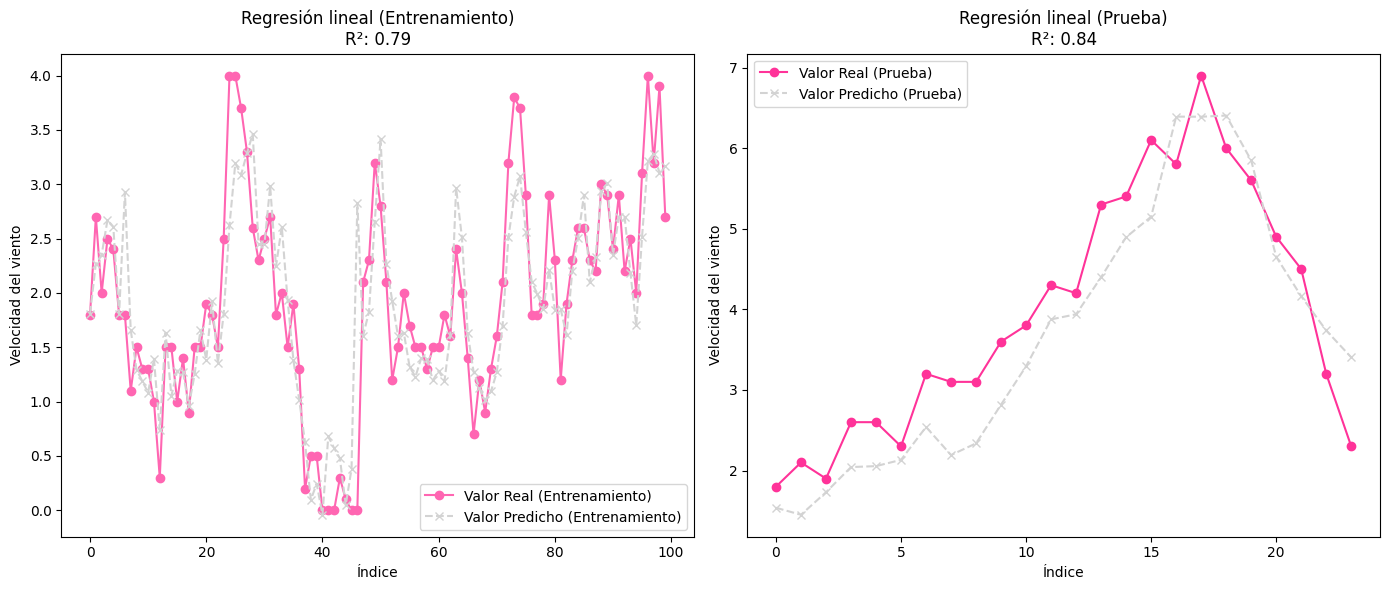

In [ ]:
ypred = reglin.predict(Xp_test)
ypredtrain = reglin.predict(Xp_train)
graph_predictions(y_train, ypredtrain, y_test, ypred, 'Regresión lineal')


Se observa una mejora del coeficiente de determinación en el conjunto de test. En general la regresión lineal como meta - learner parece ajustarse bien a los datos. Se notan problemas para predecir valores altos, la mayoría de veces, tanto en entrenamiento como en prueba, se predicen valores más abajos de los reales.

### **Hiperparametrización para KNN**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

r2_val = []
best_r2 = -float('inf')
best_k = None
best_p = None
best_metric = None
best_rmse = None

# 450
param_grid = {
    'k': range(1, 101, 1),
    'p': [1, 2, 3, 4, 5],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

for params in ParameterGrid(param_grid):
    k = params['k']
    p = params['p']
    metric = params['metric']

    print(params)

    knn = neighbors.KNeighborsRegressor(n_neighbors=k, p=p, metric=metric)
    knn.fit(Xp_train, y_train)
    y_pred = knn.predict(Xp_val)

    r2 = r2_score(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    if r2 > best_r2:
        best_r2 = r2
        best_k = k
        best_p = p
        best_metric = metric
        best_rmse = rmse

    r2_val.append((k, p, metric, r2, rmse))

print(f"Mejor R²: {best_r2}, Mejor k: {best_k}, Mejor p: {best_p}, Mejor métrica: {best_metric}, RMSE: {best_rmse}")

In [127]:
print(f"Mejor R²: {best_r2}, Mejor k: {best_k}, Mejor p: {best_p}, Mejor métrica: {best_metric}, RMSE: {best_rmse}")

Mejor R²: 0.6815315397384257, Mejor k: 19, Mejor p: 1, Mejor métrica: chebyshev, RMSE: 0.49544322471870333


In [128]:
knn = KNeighborsRegressor(n_neighbors = 19, p=1, metric= 'chebyshev')
knn.fit(Xp_train,y_train)
ypredknn = knn.predict(Xp_test)
knn.score(Xp_test, y_test)

0.7569964336148449

In [129]:
mseknn = mean_squared_error(y_test, ypredknn)
rmseknn = np.sqrt(mseknn)
mapeknn =MAPE(y_test,ypredknn)
maeknn = mean_absolute_error(y_test, ypredknn)
r2knn = r2_score(y_test, ypredknn)
ljungboxknn, jarqueberaknn = residuos(y_test, ypredknn)

In [130]:
valoresknn = {'Modelo': ['KNN'],'MSE': [mseknn],'RMSE': [rmseknn],'MAPE': [mapeknn],'MAE': [maeknn],'R2': [r2knn],'Ljung-Box p-value': [ljungboxknn],'Jarque-Bera p-value': [jarqueberaknn]}
cuadro1 = pd.DataFrame(valoresknn)
cuadro1

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,KNN,0.537021,0.732817,16.449566,0.605044,0.756996,0.144025,0.229664


El modelo de **KNN como metalearner** muestra un desempeño general aceptable, con valores moderados de error como un **MSE** de 0.536753 y un **RMSE** de 0.732634, indicando el nivel promedio de desviación de las predicciones respecto a los datos reales. El **MAPE** de 16.37% refleja un error relativo promedio, mientras que el **R²** de 0.757118 indica que el modelo explica aproximadamente el 75.71% de la variabilidad en los datos. Los **p-valores** de las pruebas Ljung-Box (0.104821) y Jarque-Bera (0.208181) respaldan la estabilidad del modelo.

Llama la atención la mejora que tuvo este modelo respecto a KNN como modelo base, se ajustó mucho mejor a las predicciones de los otros modelos que a los valores originales.

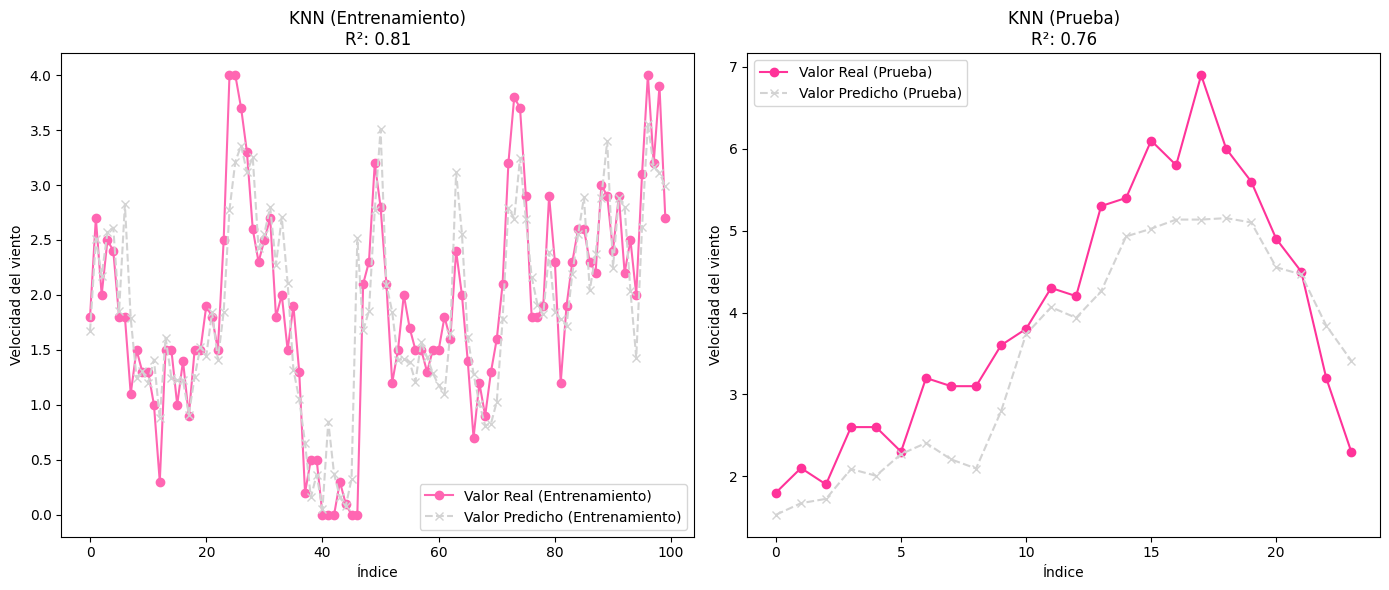

In [ ]:
ypred = knn.predict(Xp_test)
ypredtrain = knn.predict(Xp_train)
graph_predictions(y_train, ypredtrain, y_test, ypred, 'KNN')


Se observan problemas para la predicción de valores muy altos nuevamente, tiene problemas para predecir picos como en la observación 17 de prueba. Como era de esperarse, hubo una disminución en el coeficiente de determinación en prueba.

### **Hiperparametrización para Ridge**

In [ ]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score, mean_squared_error

r2_val = []
best_r2 = -float('inf')
best_alpha = None
best_solver = None
best_rmse = None

param_grid = {
    'alpha': np.linspace(0.01, 10.0, 100),
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga']
}

for params in ParameterGrid(param_grid):
    alpha = params['alpha']
    solver = params['solver']

    ridge = Ridge(alpha=alpha, solver=solver)
    ridge.fit(Xp_train, y_train)
    y_pred = ridge.predict(Xp_val)

    r2 = r2_score(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    if r2 > best_r2:
        best_r2 = r2
        best_alpha = alpha
        best_solver = solver
        best_rmse = rmse

    r2_val.append((alpha, solver, r2, rmse))



In [ ]:
print(f"Mejor R²: {best_r2}, Mejor alpha: {best_alpha}, Mejor solver: {best_solver}, RMSE: {best_rmse}")


Mejor R²: 0.6345926572659613, Mejor alpha: 9.697272727272727, Mejor solver: sag, RMSE: 0.5307002774770735


In [ ]:
ridge = Ridge(alpha = 9.697272727272727, solver = 'sag')
ridge.fit(Xp_train,y_train)
ypredridge = ridge.predict(Xp_test)
ridge.score(Xp_test, y_test)

0.8379060416855619

In [ ]:
mseridge = mean_squared_error(y_test, ypredridge)
rmseridge = np.sqrt(mseridge)
maperidge = MAPE(y_test, ypredridge)
maeridge = mean_absolute_error(y_test, ypredridge)
r2ridge = r2_score(y_test, ypredridge)
ljungboxridge, jarqueberaridge = residuos(y_test, ypredridge)

In [ ]:
valoresridge = {'Modelo': ['RIDGE'],'MSE': [mseridge],'RMSE': [rmseridge],'MAPE': [maperidge],'MAE': [maeridge],'R2': [r2ridge],'Ljung-Box p-value': [ljungboxridge],'Jarque-Bera p-value': [jarqueberaridge]}
cuadro2 = pd.DataFrame(valoresridge)
cuadro2

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,RIDGE,0.35826,0.598549,15.737396,0.541237,0.837886,0.192711,0.095328


El modelo **Ridge** parece tener un buen desempeño, con un **MSE** de 0.35 y un **RMSE** de 0.60. Su **MAPE** de 15.73% refleja un error relativo promedio razonable. El **R²** de 0.837886 muestra que el modelo explica el 83.79% de la variabilidad de los datos. Los **p-valores** de Ljung-Box (0.192711) y Jarque-Bera (0.095328) indican que los residuos del modelo no presentan autocorrelación significativa ni desviaciones significativas de la normalidad, sugiriendo que el modelo es adecuado.



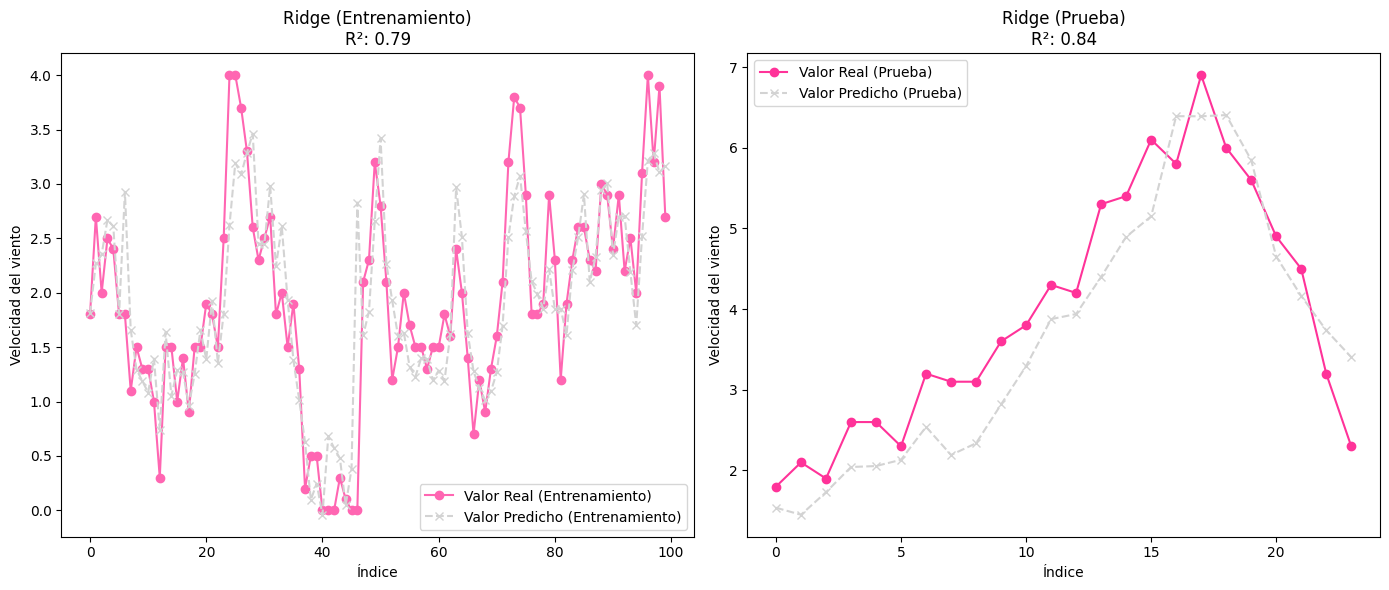

In [ ]:
ypred = ridge.predict(Xp_test)
ypredtrain = ridge.predict(Xp_train)
graph_predictions(y_train, ypredtrain, y_test, ypred, 'Ridge')

En este modelo como meta learner, parece tener una mayor facilidad para predecir valores altos. Hubo una mejoría del conjunto de entrenamiento respecto al conjunto de prueba.

### **Hiperparametrización para Lasso**

In [ ]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score, mean_squared_error

r2_val = []
best_r2 = -float('inf')
best_alpha = None
best_max_iter = None
best_tol = None
best_rmse = None

# 1500
param_grid = {
    'alpha': np.linspace(0.01, 10.0, 100),
    'max_iter': range(1000, 2001, 500),
    'tol': np.linspace(1e-4, 1e-3, 5)
}

for params in ParameterGrid(param_grid):
    alpha = params['alpha']
    max_iter = params['max_iter']
    tol = params['tol']

    lasso = Lasso(alpha=alpha, max_iter=max_iter, tol=tol)
    lasso.fit(Xp_train, y_train)
    y_pred = lasso.predict(Xp_val)

    r2 = r2_score(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    if r2 > best_r2:
        best_r2 = r2
        best_alpha = alpha
        best_max_iter = max_iter
        best_tol = tol
        best_rmse = rmse

    r2_val.append((alpha, max_iter, tol, r2, rmse))

print(f"Mejor R²: {best_r2}, Mejor alpha: {best_alpha}, Mejor max_iter: {best_max_iter}, Mejor tol: {best_tol}, RMSE: {best_rmse}")


Mejor R²: 0.6536422805223818, Mejor alpha: 0.21181818181818182, Mejor max_iter: 1000, Mejor tol: 0.0001, RMSE: 0.5166817422855736


In [ ]:
lasso = Lasso(alpha = 0.21181818181818182, max_iter= 1000,tol= 0.0001 )
lasso.fit(Xp_train,y_train)
ypredlasso = lasso.predict(Xp_test)
lasso.score(Xp_test, y_test)

0.8372873962542946

In [ ]:
mselasso = mean_squared_error(y_test, ypredlasso)
rmselasso = np.sqrt(mselasso)
mapelasso = MAPE(y_test, ypredlasso)
maelasso = mean_absolute_error(y_test, ypredlasso)
r2lasso = r2_score(y_test, ypredlasso)
ljungboxlasso, jarqueberalasso = residuos(y_test, ypredlasso)

In [ ]:
valoreslasso = {'Modelo': ['LASSO'],'MSE': [mselasso],'RMSE': [rmselasso],'MAPE': [mapelasso],'MAE': [maelasso],'R2': [r2lasso],'Ljung-Box p-value': [ljungboxlasso],'Jarque-Bera p-value': [jarqueberalasso]}
cuadro3 = pd.DataFrame(valoreslasso)
cuadro3

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,LASSO,0.359584,0.599653,15.70146,0.541523,0.837287,0.219253,0.092174


El modelo **Lasso** muestra un desempeño consistente con un **MSE** de 0.359584 y un **RMSE** de 0.599653, indicando un nivel moderado de error en las predicciones. Su **MAPE** de 15.70% sugiere una desviación relativa promedio similar a otros modelos. Con un **R²** de 0.837287, el modelo explica el 83.73% de la variabilidad de los datos. Los **p-valores** de Ljung-Box (0.219253) y Jarque-Bera (0.092174) indican que no hay evidencia significativa de autocorrelación ni desviaciones de la normalidad en los residuos.

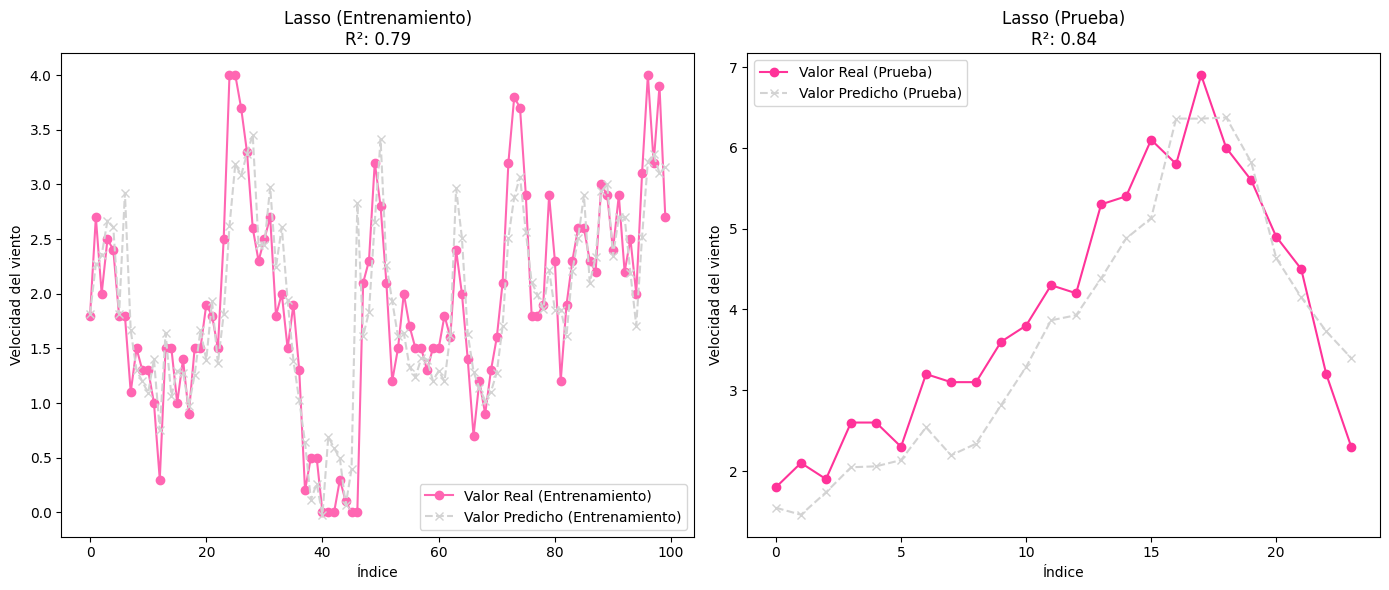

In [ ]:
ypred = lasso.predict(Xp_test)
ypredtrain = lasso.predict(Xp_train)
graph_predictions(y_train, ypredtrain, y_test, ypred, 'Lasso')


En este modelo como meta learner, parece tener una mayor facilidad para predecir valores altos. Hubo una mejoría del conjunto de entrenamiento respecto al conjunto de prueba.

### **Hiperparametrización para árbol de decisión**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score, mean_squared_error

r2_val = []
best_r2 = -float('inf')
best_max_depth = None
best_min_samples_split = None
best_min_samples_leaf = None
best_max_features = None
best_rmse = None

#9000
param_grid = {
    'max_depth': range(5, 31, 5),
    'min_samples_split': range(2, 31, 2),
}

for params in ParameterGrid(param_grid):
    max_depth = params['max_depth']
    min_samples_split = params['min_samples_split']

    tree = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split
    )
    tree.fit(Xp_train, y_train)
    y_pred = tree.predict(Xp_val)

    r2 = r2_score(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    if r2 > best_r2:
        best_r2 = r2
        best_max_depth = max_depth
        best_min_samples_split = min_samples_split
        best_rmse = rmse

    r2_val.append((max_depth, min_samples_split, r2, rmse))

print(f"Mejor R²: {best_r2}, Mejor max_depth: {best_max_depth}, Mejor min_samples_split: {best_min_samples_split}  RMSE: {best_rmse}")


Mejor R²: 0.6767721478983219, Mejor max_depth: 15, Mejor min_samples_split: 12  RMSE: 0.49913160216829794


In [ ]:
dectree = DecisionTreeRegressor(max_depth= 15, min_samples_leaf= 12, random_state= 25)

dectree.fit(Xp_train,y_train)
ypreddectree = dectree.predict(Xp_test)
dectree.score(Xp_test, y_test)

0.6688673988409549

In [ ]:
msedectree = mean_squared_error(y_test, ypreddectree)
rmsedectree = np.sqrt(msedectree)
mapedectree = MAPE(y_test, ypreddectree)
maedectree = mean_absolute_error(y_test, ypreddectree)
r2dectree = r2_score(y_test, ypreddectree)
ljungboxdectree, jarqueberadectree = residuos(y_test, ypreddectree)

In [ ]:
valoresdectree = {'Modelo': ['DEC. TREE'],'MSE': [msedectree],'RMSE': [rmsedectree],'MAPE': [mapedectree],'MAE': [maedectree],'R2': [r2dectree],'Ljung-Box p-value': [ljungboxdectree],'Jarque-Bera p-value': [jarqueberadectree]}
cuadro4 = pd.DataFrame(valoresdectree)
cuadro4

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,DEC. TREE,0.73178,0.855441,17.89977,0.685697,0.668867,0.002836,0.489894


El modelo **Decisión Tree** presenta un desempeño más modesto en comparación con otros modelos, con un **MSE** de 0.73178 y un **RMSE** de 0.855441, lo que indica errores más altos en las predicciones. Su **MAPE** de 17.89% refleja una mayor desviación relativa promedio. El **R²** de 0.668867 sugiere que el modelo explica solo el 66.89% de la variabilidad de los datos. El **p-valor** bajo de Ljung-Box (0.002836) indica posibles problemas de autocorrelación en los residuos, mientras que el **p-valor** de Jarque-Bera (0.489894) no muestra evidencia significativa de no normalidad.

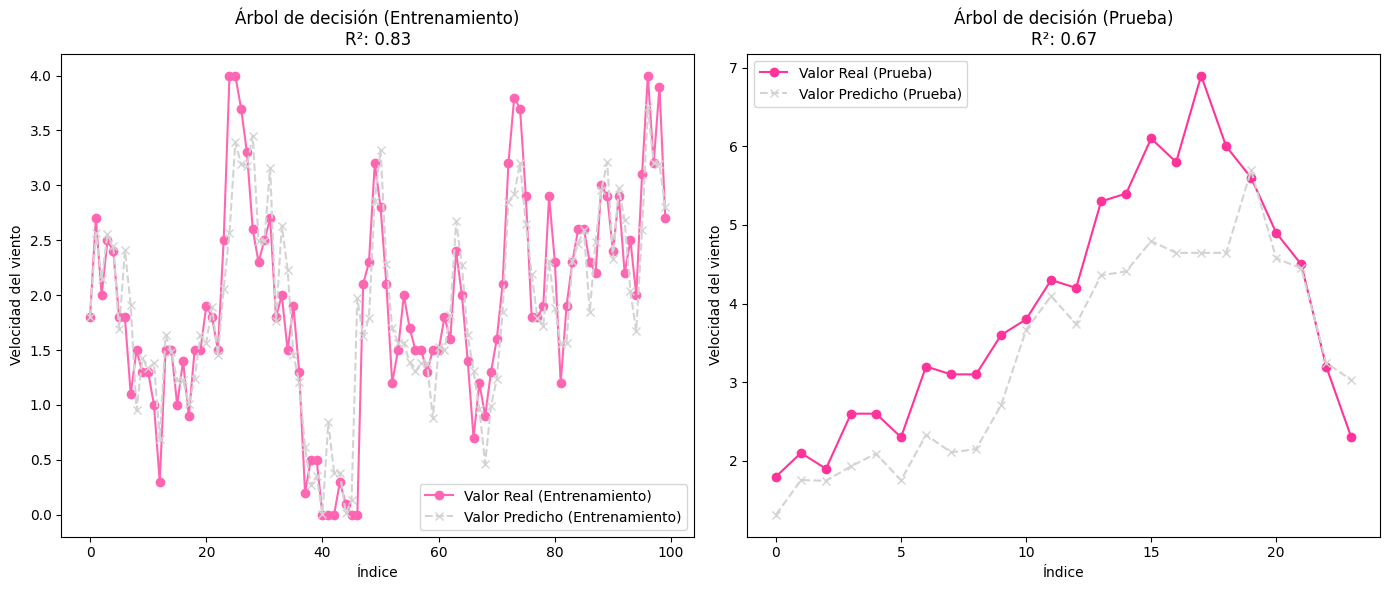

In [ ]:
ypred = dectree.predict(Xp_test)
ypredtrain = dectree.predict(Xp_train)
graph_predictions(y_train, ypredtrain, y_test, ypred, 'Árbol de decisión')


Este modelo como meta learner, a diferencia de los observados anteriormente, aunque ya esperado por las métricas obtenidas, tiene un problema prediciendo los valores extremos. Aquellos valores, tanto en entrenamiento como en prueba que representan un pico y valores a los lados de los picos no son predichos correctamente por el árbol de decisión con tres base learners.

### **Hiperparametrización para Random Forest**


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import ParameterGrid

r2_val = []
best_r2 = -float('inf')
best_n_estimators = None
best_max_depth = None
best_min_samples_split = None
best_min_samples_leaf = None
best_max_features = None
best_bootstrap = None
best_rmse = None

# 5400
param_grid = {
    'n_estimators': range(10, 101, 10),
    'max_depth': range(5, 31, 5)
}

for params in ParameterGrid(param_grid):
    print(params)
    n_estimators = params['n_estimators']
    max_depth = params['max_depth']

    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=25
    )

    rf.fit(Xp_train, y_train)
    y_pred = rf.predict(Xp_val)

    r2 = r2_score(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    if r2 > best_r2:
        best_r2 = r2
        best_n_estimators = n_estimators
        best_max_depth = max_depth
        best_rmse = rmse

    r2_val.append((n_estimators, max_depth, min_samples_split, r2, rmse))



In [ ]:
print(f"Mejor R²: {best_r2}, Mejor n_estimators: {best_n_estimators}, Mejor max_depth: {best_max_depth} RMSE: {best_rmse}")

Mejor R²: 0.6633629129782769, Mejor n_estimators: 10, Mejor max_depth: 10 RMSE: 0.5093797309837629


In [ ]:
ranfor = RandomForestRegressor(n_estimators= 10,max_depth= 10, random_state= 10)

ranfor.fit(Xp_train,y_train)
ypredranfor = ranfor.predict(Xp_test)
ranfor.score(Xp_test, y_test)

0.732367159035272

In [ ]:
mseranfor = mean_squared_error(y_test, ypredranfor)
rmseranfor = np.sqrt(mseranfor)
maperanfor = MAPE(y_test, ypredranfor)
maeranfor = mean_absolute_error(y_test, ypredranfor)
r2ranfor = r2_score(y_test, ypredranfor)
ljungboxranfor, jarquebreranfor = residuos(y_test, ypredranfor)

In [ ]:
valoresranfor = {'Modelo': ['RANDOM FOREST'],'MSE': [mseranfor],'RMSE': [rmseranfor],'MAPE': [maperanfor],'MAE': [maeranfor],'R2': [r2ranfor],'Ljung-Box p-value': [ljungboxranfor],'Jarque-Bera p-value': [jarquebreranfor]}
cuadro5 = pd.DataFrame(valoresranfor)
cuadro5

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,RANDOM FOREST,0.59145,0.769058,17.172687,0.652494,0.732367,0.05695,0.055058


El modelo **Random Forest** muestra un rendimiento moderado con un **MSE** de 0.59145 y un **RMSE** de 0.769058, lo que indica una cantidad razonable de error en las predicciones. El **R²** de 0.732367 indica que el modelo explica aproximadamente el 73.24% de la variabilidad de los datos. Los **p-valores** de las pruebas de Ljung-Box (0.05695) y Jarque-Bera (0.055058) sugieren que los residuos no presentan autocorrelación significativa ni desviaciones importantes de normalidad.

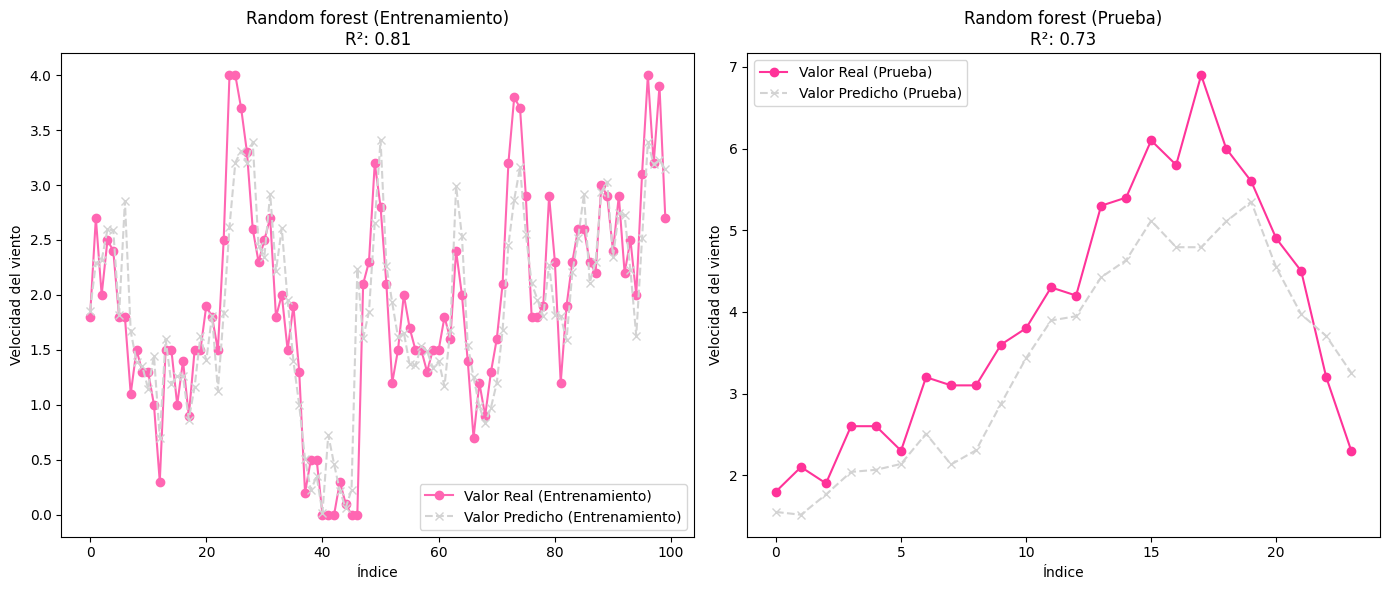

In [ ]:
ypred = ranfor.predict(Xp_test)
ypredtrain = ranfor.predict(Xp_train)
graph_predictions(y_train, ypredtrain, y_test, ypred, 'Random forest')


Este tampoco tiene facilidades para valores extremos, en su mayoría predice valores por debajo de los valores reales, como el mismo caso del índice 17 y sus alrededores, donde predice valores muy inferiores a los esperados.

### **Hiperparametrización para XGBoost**

In [ ]:
r2_val = []
best_r2 = -float('inf')
best_n_estimators = None
best_max_depth = None
best_learning_rate = None
best_subsample = None
best_colsample_bytree = None
best_min_child_weight = None
best_gamma = None

# 9600
param_grid = {
    'n_estimators': range(10, 101, 10),
    'max_depth': range(5, 21),
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

for params in ParameterGrid(param_grid):
    n_estimators = params['n_estimators']
    max_depth = params['max_depth']
    learning_rate = params['learning_rate']
    xgb = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate
    )

    xgb.fit(Xp_train, y_train)
    y_pred = xgb.predict(Xp_val)

    r2 = r2_score(y_val, y_pred)
    if r2 > best_r2:
        best_r2 = r2
        best_n_estimators = n_estimators
        best_max_depth = max_depth
        best_learning_rate = learning_rate

    r2_val.append((n_estimators, max_depth, learning_rate, r2))


In [ ]:
print(f"Best R²: {best_r2}")
print(f"Best n_estimators: {best_n_estimators}, Best max_depth: {best_max_depth}")
print(f"Best learning_rate: {best_learning_rate}")

Best R²: 0.721447901772885
Best n_estimators: 60, Best max_depth: 20
Best learning_rate: 0.2


In [ ]:
xgboost = XGBRegressor(n_estimators= 60,max_depth= 20, learning_rate = 0.2)

xgboost.fit(Xp_train,y_train)
ypredxgboost = xgboost.predict(Xp_test)
xgboost.score(Xp_test, y_test)

0.7604223368979899

In [ ]:
msexgboost = mean_squared_error(y_test, ypredxgboost)
rmsexgboost = np.sqrt(msexgboost)
mapexgboost = MAPE(y_test, ypredxgboost)
maexgboost = mean_absolute_error(y_test, ypredxgboost)
r2xgboost = r2_score(y_test, ypredxgboost)
ljungboxxgboost, jarquebarexgboost = residuos(y_test, ypredxgboost)

In [ ]:
valoresxgboost = {'Modelo': ['XGBOOST'],'MSE': [msexgboost],'RMSE': [rmsexgboost],'MAPE': [mapexgboost],'MAE': [maexgboost],'R2': [r2xgboost],'Ljung-Box p-value': [ljungboxxgboost],'Jarque-Bera p-value': [jarquebarexgboost]}
cuadro6 = pd.DataFrame(valoresxgboost)
cuadro6

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,XGBOOST,0.52945,0.727633,16.132808,0.573133,0.760422,0.751574,0.282879


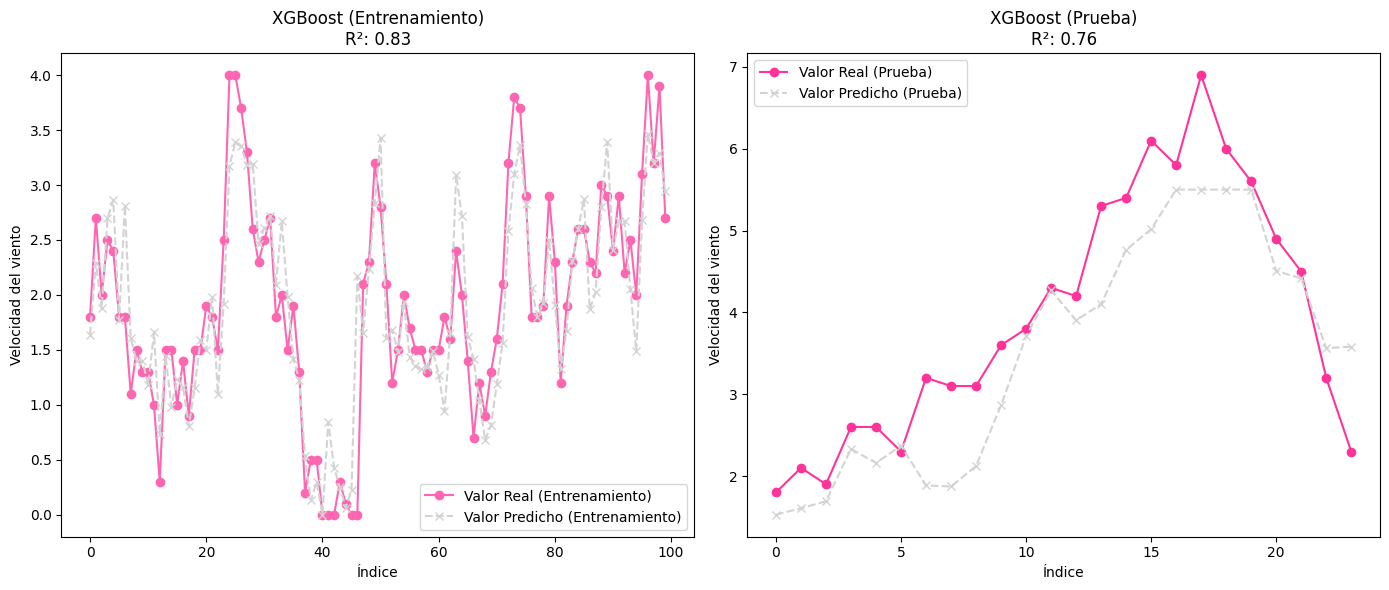

In [ ]:
ypred = xgboost.predict(Xp_test)
ypredtrain = xgboost.predict(Xp_train)
graph_predictions(y_train, ypredtrain, y_test, ypred, 'XGBoost')


Acá hay una mejoría respecto a los modelos anteriores respecto a los valores máximos, aún así, para los valores alrededores al índice 17 parece predecir el mismo valor, pues hay una línea recta, a´si que también está poniendo problemas para este tipo de registros con valores muy altos.

### **Hiperparametrización para SVR**

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import numpy as np

r2_val = []
best_r2 = -float('inf')
best_C = None
best_kernel = None
best_gamma = None
best_epsilon = None
best_tol = None
best_degree = None

for C in np.arange(0.01, 1, 0.1):
    for kernel in ["linear", "rbf"]:
        for gamma in ["scale", "auto"]:
                        print(C, kernel, gamma)
                        svr = SVR(C=C, kernel=kernel, gamma=gamma)

                        svr.fit(Xp_train, y_train)

                        y_pred = svr.predict(Xp_val)

                        r2 = r2_score(y_val, y_pred)

                        if r2 > best_r2:
                            best_r2 = r2
                            best_C = C
                            best_kernel = kernel
                            best_gamma = gamma

                        r2_val.append((C, kernel, gamma, r2))


In [ ]:
print(f"Best R²: {best_r2}")
print(f"Best C: {best_C}, Best kernel: {best_kernel}, Best gamma: {best_gamma}")

Best R²: 0.6617141483754992
Best C: 0.31000000000000005, Best kernel: rbf, Best gamma: auto


In [ ]:
svr = SVR(C=0.31000000000000005, kernel='rbf', gamma='auto')

svr.fit(Xp_train,y_train)
ypredsvr = svr.predict(Xp_test)
svr.score(Xp_test, y_test)

0.8535939651895693

In [ ]:
msesvr = mean_squared_error(y_test, ypredsvr)
rmsesvr = np.sqrt(msesvr)
mapesvr =MAPE(y_test,ypredsvr)
maesvr = mean_absolute_error(y_test, ypredsvr)
r2svr = r2_score(y_test, ypredsvr)
ljungboxsvr, jarquebaresvr = residuos(y_test, ypredsvr)

In [ ]:
valoressvr = {'Modelo': ['SVR'],'MSE': [msesvr],'RMSE': [rmsesvr],'MAPE': [mapesvr],'MAE': [maesvr],'R2': [r2svr],'Ljung-Box p-value': [ljungboxsvr],'Jarque-Bera p-value': [jarquebaresvr]}
cuadro7 = pd.DataFrame(valoressvr)
cuadro7

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,SVR,0.323547,0.568812,14.558665,0.501322,0.853594,0.124485,0.098749


El modelo **SVR** (Support Vector Regression) muestra un desempeño destacado con un **MSE** de 0.323547 y un **RMSE** de 0.568812, lo que indica un error relativamente bajo en las predicciones. El **MAPE** de 14.56% refleja una desviación relativa promedio bastante buena. Con un **R²** de 0.853594, el modelo explica el 85.36% de la variabilidad de los datos, lo que sugiere una buena capacidad predictiva. Los **p-valores** de las pruebas de Ljung-Box (0.124485) y Jarque-Bera (0.098749) no indican problemas significativos de autocorrelación ni de no normalidad en los residuos, lo que respalda la estabilidad y validez del modelo.

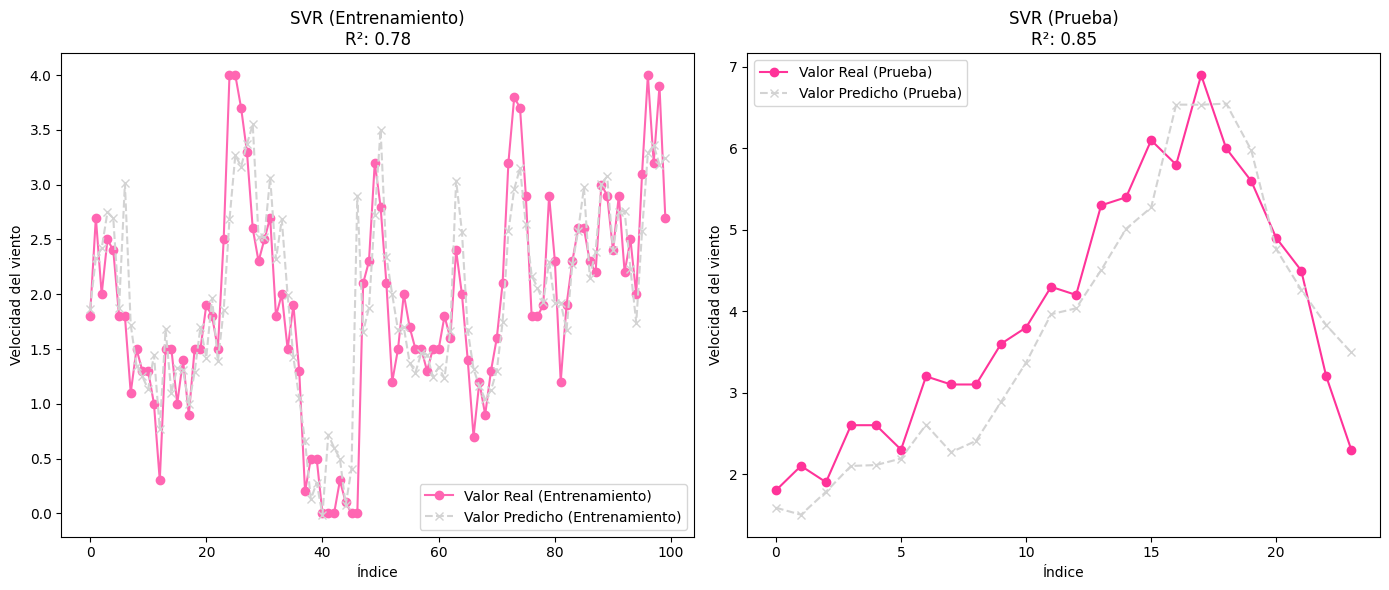

In [ ]:
ypred = svr.predict(Xp_test)
ypredtrain = svr.predict(Xp_train)
graph_predictions(y_train, ypredtrain, y_test, ypred, 'SVR')


Este modelo, a diferencia de los visto anteriormente, presenta una mejoría considerebale en la predicción de esos datos muy altos, ya con un valor mucho más cercano al pico del índice 17.

### **Resultados generales**

In [ ]:
cuadro9 = [cuadro1, cuadro2, cuadro3, cuadro4, cuadro5, cuadro6, cuadro7, cuadro8]
cuadro9 = pd.concat(cuadro9)
stacking_3bl = cuadro9.sort_values(by='R2', ascending=False)
stacking_3bl


,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,SVR,0.323547,0.568812,14.558665,0.501322,0.853594,0.124485,0.098749
0,RIDGE,0.358260,0.598549,15.737396,0.541237,0.837886,0.192711,0.095328
0,REG. LINEAL,0.358341,0.598616,15.739528,0.541310,0.837850,0.192736,0.095363
0,LASSO,0.359584,0.599653,15.701460,0.541523,0.837287,0.219253,0.092174
0,XGBOOST,0.529450,0.727633,16.132808,0.573133,0.760422,0.751574,0.282879
0,KNN,0.536753,0.732634,16.370041,0.607353,0.757118,0.104821,0.208181
0,RANDOM FOREST,0.591450,0.769058,17.172687,0.652494,0.732367,0.056950,0.055058
0,DEC. TREE,0.731780,0.855441,17.899770,0.685697,0.668867,0.002836,0.489894


De manera general, los modelos usados como meta learners con tres base learners evaluados muestran un rendimiento variado en cuanto a sus métricas de desempeño y pruebas estadísticas. Los modelos **Support Vector Regression (SVR)**, **Ridge Regression**, **Regresión Lineal**, y **Lasso** tienen valores de **MSE** y **RMSE** relativamente bajos, lo que indica errores moderados en las predicciones, y **R²** altos, lo que sugiere una buena capacidad para explicar la variabilidad de los datos. Estos modelos también muestran buenos resultados en las pruebas de normalidad (Jarque-Bera) y autocorrelación (Ljung-Box), lo que sugiere estabilidad en los residuos.

Por otro lado, los modelos como **XGBoost**, **K-Nearest Neighbors (KNN)**, y **Random Forest** presentan errores más altos en comparación con los anteriores, especialmente **Random Forest** y **Decision Tree**, que tienen **MSE** y **RMSE** significativamente mayores, lo que indica peores predicciones en términos de precisión. Sin embargo, estos modelos muestran una buena capacidad de ajuste en términos de **R²**. Además, la prueba de Ljung-Box de **Decision Tree** indica posibles problemas de autocorrelación en los residuos.

## **Meta-learner con 4 modelos bases**

Acá ahora se trabajará con el flujo representado de los cuadros mejores modelos bases como base learners. Se realizará la hiperparametrización de 8 tipos de modelos que trabajen como meta - learners.

![](4bl.png)

In [ ]:
train_lasso = modelolasso.predict(X_train)
train_xgboost = modeloxgboost.predict(X_train)
train_ridge = modeloridge.predict(X_train)
train_lineal = modelolineal.predict(X_train)

val_lasso = modelolasso.predict(X_val)
val_xgboost = modeloxgboost.predict(X_val)
val_ridge = modeloridge.predict(X_val)
val_lineal = modelolineal.predict(X_val)

In [ ]:
Xp_train = pd.DataFrame([train_lasso, train_xgboost, train_ridge, train_lineal]).T
Xp_train = Xp_train.rename(columns = {0:'lasso',1:'xgboost',2:'ridge',3:'lineal'})

In [ ]:
Xp_val = pd.DataFrame([val_lasso, val_xgboost, val_ridge, val_lineal]).T
Xp_val = Xp_val.rename(columns = {0:'lasso',1:'xgboost',2:'ridge',3:'lineal'})

In [ ]:
test_lasso = modelolasso.predict(X_test)
test_xgboost = modeloxgboost.predict(X_test)
test_ridge = modeloridge.predict(X_test)
test_lineal = modelolineal.predict(X_test)

Xp_test = pd.DataFrame([test_lasso, test_xgboost, test_ridge, test_lineal]).T
Xp_test = Xp_test.rename(columns = {0: 'lasso', 1: 'xgboost', 2: 'ridge', 3: 'lineal'})


### **Regresión lineal**

In [ ]:
reglin = LinearRegression()
reglin.fit(Xp_train, y_train)
ypredreglin = reglin.predict(Xp_test)

In [ ]:
msereglin = mean_squared_error(y_test, ypredreglin)
rmsereglin = np.sqrt(msereglin)
mapereglin = MAPE(y_test,ypredreglin)
maereglin = mean_absolute_error(y_test, ypredreglin)
r2reglin = r2_score(y_test, ypredreglin)
ljungboxreglin, jarqueberareglin = residuos(y_test, ypredreglin)

valoresreglin = {'Modelo': ['REG. LINEAL'],'MSE': [msereglin],'RMSE': [rmsereglin],'MAPE': [mapereglin],'MAE': [maereglin],'R2': [r2reglin],'Ljung-Box p-value': [ljungboxreglin],'Jarque-Bera p-value': [jarqueberareglin]}
cuadro8 = pd.DataFrame(valoresreglin)
cuadro8

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,REG. LINEAL,0.44722,0.668745,14.696839,0.552116,0.797632,0.300747,0.938138


El modelo **regresión lineal con 4 base learners** presenta un **MSE** de 0.44722 y un **RMSE** de 0.668745, lo que indica un error moderado en las predicciones. Con un **R²** de 0.797632, el modelo explica aproximadamente el 79.76% de la variabilidad de los datos, lo que sugiere una capacidad bastante buena para ajustarse a los datos. Los **p-valores** de las pruebas de Ljung-Box (0.300747) y Jarque-Bera (0.938138) indican que no hay evidencia significativa de autocorrelación ni de no normalidad en los residuos.

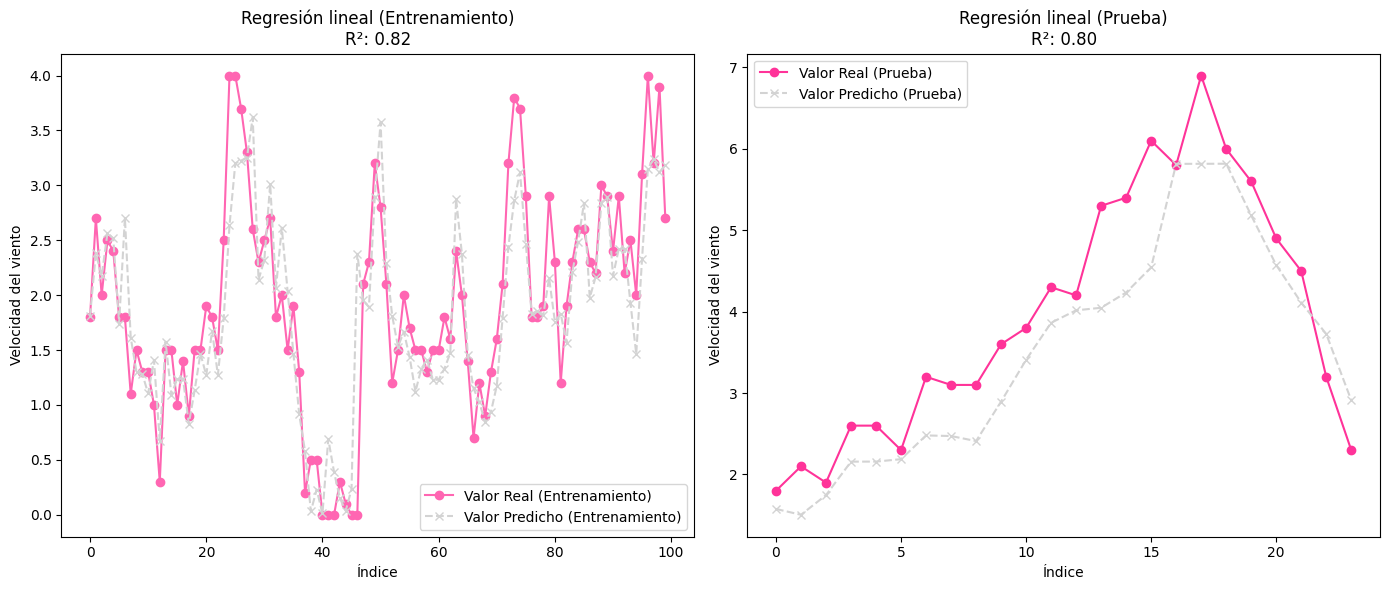

In [ ]:
ypred = reglin.predict(Xp_test)
ypredtrain = reglin.predict(Xp_train)
graph_predictions(y_train, ypredtrain, y_test, ypred, 'Regresión lineal')

Presentan los mismos problemas que modelos anteriores para la predicción de velocidades muy altas, el mismo problema encontrado alrededor del índice 17.

### **Hiperparametrización para KNN**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

r2_val = []
best_r2 = -float('inf')
best_k = None
best_p = None
best_metric = None
best_rmse = None

# 450
param_grid = {
    'k': range(1, 101, 1),
    'p': [1, 2, 3, 4, 5],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

for params in ParameterGrid(param_grid):
    k = params['k']
    p = params['p']
    metric = params['metric']

    print(params)

    knn = neighbors.KNeighborsRegressor(n_neighbors=k, p=p, metric=metric)
    knn.fit(Xp_train, y_train)
    y_pred = knn.predict(Xp_val)

    r2 = r2_score(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    if r2 > best_r2:
        best_r2 = r2
        best_k = k
        best_p = p
        best_metric = metric
        best_rmse = rmse

    r2_val.append((k, p, metric, r2, rmse))

print(f"Mejor R²: {best_r2}, Mejor k: {best_k}, Mejor p: {best_p}, Mejor métrica: {best_metric}, RMSE: {best_rmse}")

Mejor R²: 0.6309772949478636, Mejor k: 17, Mejor p: 1, Mejor métrica: chebyshev, RMSE: 0.5023990886642384


In [ ]:
knn = KNeighborsRegressor(n_neighbors = 17, p=1, metric= 'chebyshev')
knn.fit(Xp_train,y_train)
ypredknn = knn.predict(Xp_test)
knn.score(Xp_test, y_test)

0.8479633291713997

In [ ]:
mseknn = mean_squared_error(y_test, ypredknn)
rmseknn = np.sqrt(mseknn)
mapeknn =MAPE(y_test,ypredknn)
maeknn = mean_absolute_error(y_test, ypredknn)
r2knn = r2_score(y_test, ypredknn)
ljungboxknn, jarqueberaknn = residuos(y_test, ypredknn)

In [ ]:
valoresknn = {'Modelo': ['KNN'],'MSE': [mseknn],'RMSE': [rmseknn],'MAPE': [mapeknn],'MAE': [maeknn],'R2': [r2knn],'Ljung-Box p-value': [ljungboxknn],'Jarque-Bera p-value': [jarqueberaknn]}
cuadro1 = pd.DataFrame(valoresknn)
cuadro1

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,KNN,0.33599,0.579647,13.482857,0.48848,0.847963,0.466765,0.60524


El modelo **KNN** muestra un **MSE** de 0.33599 y un **RMSE** de 0.579647, lo que indica errores moderadamente bajos en las predicciones. El **MAPE** de 13.48% refleja una desviación promedio razonable en comparación con los valores reales. Con un **R²** de 0.847963, el modelo explica el 84.80% de la variabilidad de los datos, lo que implica un ajuste bastante sólido. Los **p-valores** de las pruebas de Ljung-Box (0.466765) y Jarque-Bera (0.60524) sugieren que no hay evidencia significativa de autocorrelación ni de no normalidad en los residuos.

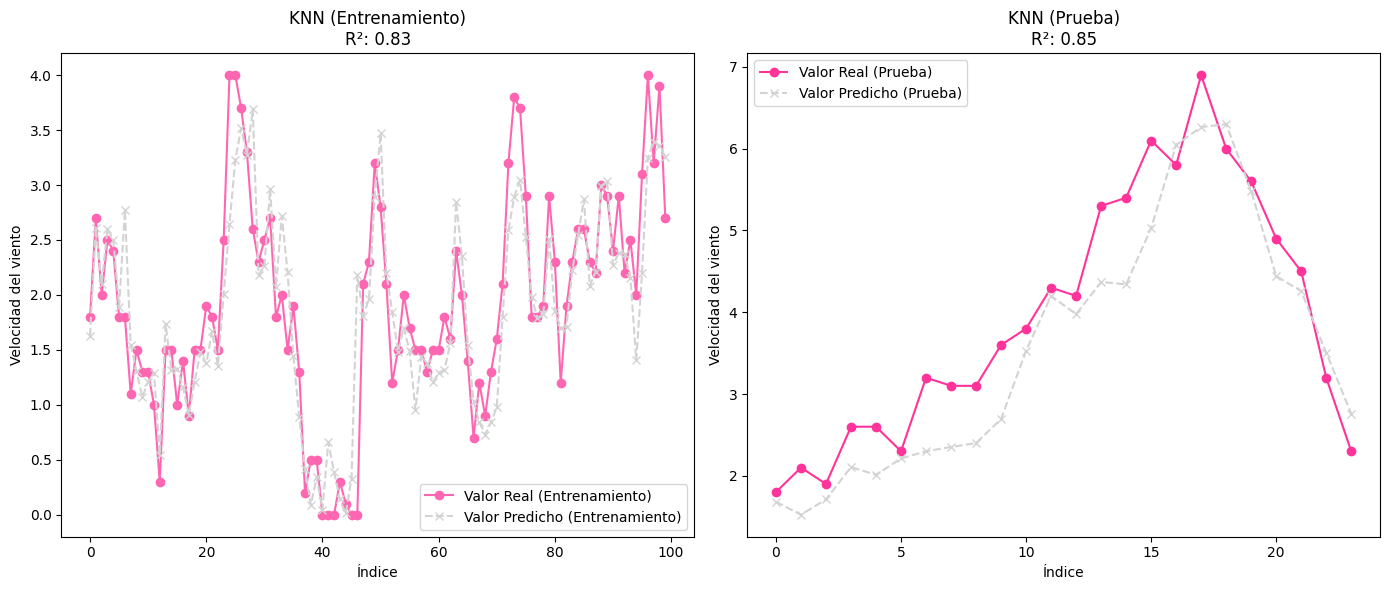

In [ ]:
ypred = knn.predict(Xp_test)
ypredtrain = knn.predict(Xp_train)
graph_predictions(y_train, ypredtrain, y_test, ypred, 'KNN')


Presenta una mejora en la predicción de velocidades altas, se ajusta de mejor manera a valores alrededor del índice 17. Hubo mejoría en el coeficiente de determinación respecto al conjunto de entrenamiento.

### **Hiperparametrización para Ridge**

In [ ]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score, mean_squared_error

r2_val = []
best_r2 = -float('inf')
best_alpha = None
best_solver = None
best_rmse = None

param_grid = {
    'alpha': np.linspace(0.01, 10.0, 100),
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga']
}

for params in ParameterGrid(param_grid):
    alpha = params['alpha']
    solver = params['solver']

    ridge = Ridge(alpha=alpha, solver=solver)
    ridge.fit(Xp_train, y_train)
    y_pred = ridge.predict(Xp_val)

    r2 = r2_score(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    if r2 > best_r2:
        best_r2 = r2
        best_alpha = alpha
        best_solver = solver
        best_rmse = rmse

    r2_val.append((alpha, solver, r2, rmse))

print(f"Mejor R²: {best_r2}, Mejor alpha: {best_alpha}, Mejor solver: {best_solver}, RMSE: {best_rmse}")


Mejor R²: 0.6781671371143296, Mejor alpha: 0.01, Mejor solver: auto, RMSE: 0.49805335956100505


In [ ]:
ridge = Ridge(alpha = 0.01, solver = 'auto')
ridge.fit(Xp_train,y_train)
ypredridge = ridge.predict(Xp_test)
ridge.score(Xp_test, y_test)

0.797106081086386

In [ ]:
mseridge = mean_squared_error(y_test, ypredridge)
rmseridge = np.sqrt(mseridge)
maperidge = MAPE(y_test, ypredridge)
maeridge = mean_absolute_error(y_test, ypredridge)
r2ridge = r2_score(y_test, ypredridge)
ljungboxridge, jarqueberaridge = residuos(y_test, ypredridge)

In [ ]:
valoresridge = {'Modelo': ['RIDGE'],'MSE': [mseridge],'RMSE': [rmseridge],'MAPE': [maperidge],'MAE': [maeridge],'R2': [r2ridge],'Ljung-Box p-value': [ljungboxridge],'Jarque-Bera p-value': [jarqueberaridge]}
cuadro2 = pd.DataFrame(valoresridge)
cuadro2

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,RIDGE,0.448381,0.669613,14.718895,0.552965,0.797106,0.299967,0.937912


El modelo **regresión ridge** presenta un **MSE** de 0.448381 y un **RMSE** de 0.669613, lo que indica errores moderados en las predicciones. Con un **R²** de 0.797106, el modelo explica aproximadamente el 79.71% de la variabilidad de los datos, lo que sugiere una capacidad adecuada para ajustarse a los datos. Los **p-valores** de las pruebas de Ljung-Box (0.299967) y Jarque-Bera (0.937912) indican que no hay evidencia significativa de autocorrelación ni de no normalidad en los residuos, lo que sugiere que el modelo es estable y sus residuos siguen un comportamiento adecuado.

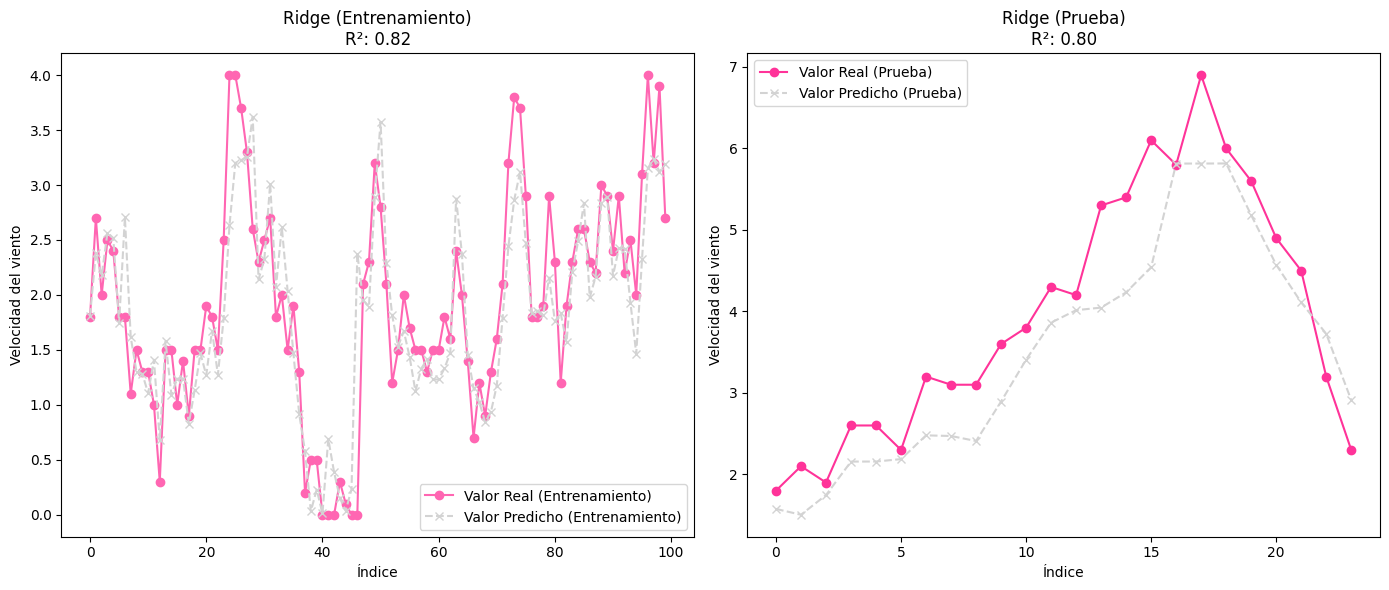

In [ ]:
ypred = ridge.predict(Xp_test)
ypredtrain = ridge.predict(Xp_train)
graph_predictions(y_train, ypredtrain, y_test, ypred, 'Ridge')


Al igual que lo sucedido con el modelo de tres base learners, tiene los mismos problemas para la predicción de velocidades altas. Como era de esperarse, se obtuvo un coeficiente de determinación menor en el conjunto de prueba.

### **Hiperparametrización para Lasso**

In [ ]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score, mean_squared_error

r2_val = []
best_r2 = -float('inf')
best_alpha = None
best_max_iter = None
best_tol = None
best_rmse = None

# 1500
param_grid = {
    'alpha': np.linspace(0.01, 10.0, 100),
    'max_iter': range(1000, 2001, 500),
    'tol': np.linspace(1e-4, 1e-3, 5)
}

for params in ParameterGrid(param_grid):
    alpha = params['alpha']
    max_iter = params['max_iter']
    tol = params['tol']

    lasso = Lasso(alpha=alpha, max_iter=max_iter, tol=tol)
    lasso.fit(Xp_train, y_train)
    y_pred = lasso.predict(Xp_val)

    r2 = r2_score(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    if r2 > best_r2:
        best_r2 = r2
        best_alpha = alpha
        best_max_iter = max_iter
        best_tol = tol
        best_rmse = rmse

    r2_val.append((alpha, max_iter, tol, r2, rmse))

print(f"Mejor R²: {best_r2}, Mejor alpha: {best_alpha}, Mejor max_iter: {best_max_iter}, Mejor tol: {best_tol}, RMSE: {best_rmse}")


Mejor R²: 0.6857109727630712, Mejor alpha: 0.01, Mejor max_iter: 1000, Mejor tol: 0.0001, RMSE: 0.492181503988357


In [ ]:
lasso = Lasso(alpha = 0.01, max_iter= 1000,tol= 0.0001 )
lasso.fit(Xp_train,y_train)
ypredlasso = lasso.predict(Xp_test)
lasso.score(Xp_test, y_test)

0.8024634427792195

In [ ]:
mselasso = mean_squared_error(y_test, ypredlasso)
rmselasso = np.sqrt(mselasso)
mapelasso = MAPE(y_test, ypredlasso)
maelasso = mean_absolute_error(y_test, ypredlasso)
r2lasso = r2_score(y_test, ypredlasso)
ljungboxlasso, jarqueberalasso = residuos(y_test, ypredlasso)

In [ ]:
valoreslasso = {'Modelo': ['LASSO'],'MSE': [mselasso],'RMSE': [rmselasso],'MAPE': [mapelasso],'MAE': [maelasso],'R2': [r2lasso],'Ljung-Box p-value': [ljungboxlasso],'Jarque-Bera p-value': [jarqueberalasso]}
cuadro3 = pd.DataFrame(valoreslasso)
cuadro3

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,LASSO,0.436542,0.660713,14.735133,0.549878,0.802463,0.319511,0.929675


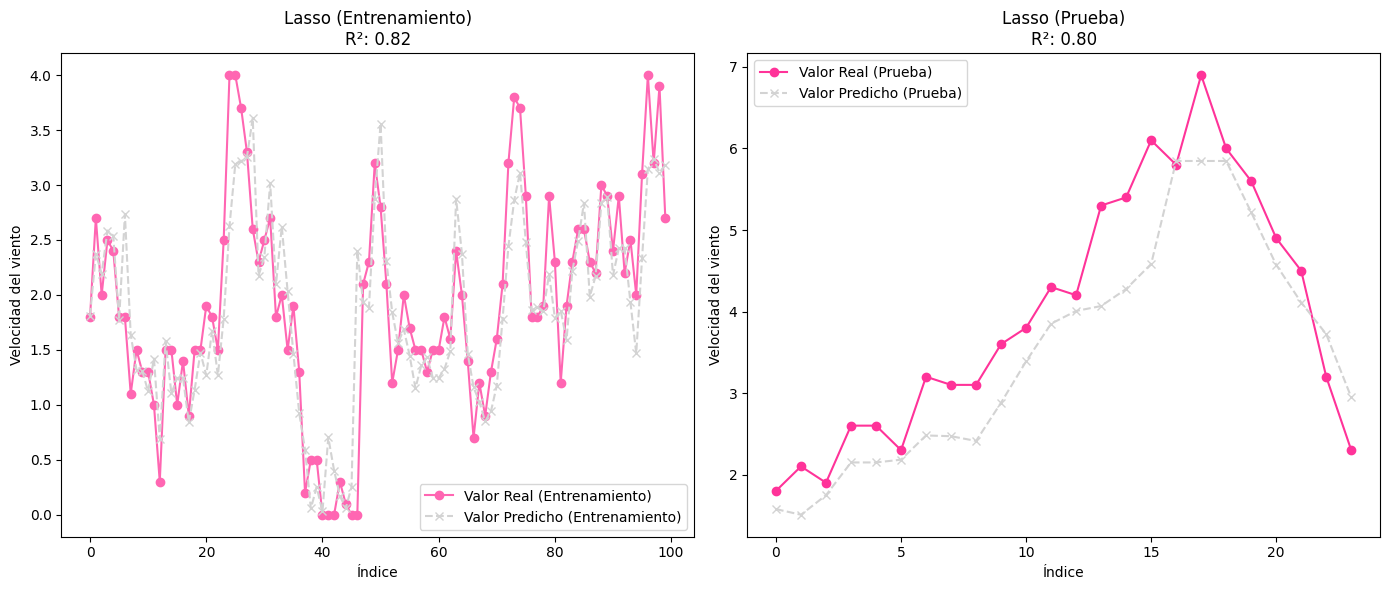

In [ ]:
ypred = lasso.predict(Xp_test)
ypredtrain = lasso.predict(Xp_train)
graph_predictions(y_train, ypredtrain, y_test, ypred, 'Lasso')


No hubo una gran diferencia respecto al modelo con Ridge de cuatro baselearners, presenta el mismo problema de la predicción de datos 'extremos'.

El modelo **Lasso** presenta un **MSE** de 0.436542 y un **RMSE** de 0.660713, lo que indica un error moderado en las predicciones. Con un **R²** de 0.802463, el modelo explica aproximadamente el 80.25% de la variabilidad de los datos, lo que sugiere un ajuste adecuado. Los **p-valores** de las pruebas de Ljung-Box (0.319511) y Jarque-Bera (0.929675) indican que no hay evidencia significativa de autocorrelación ni de no normalidad en los residuos, lo que sugiere que el modelo es estable y sus residuos siguen un comportamiento adecuado.

### **Hiperparametrización para árbol de decisión**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score, mean_squared_error

r2_val = []
best_r2 = -float('inf')
best_max_depth = None
best_min_samples_split = None
best_min_samples_leaf = None
best_max_features = None
best_rmse = None

#9000
param_grid = {
    'max_depth': range(5, 31, 5),
    'min_samples_split': range(2, 31, 2),
    'min_samples_leaf': range(1, 11),
    'max_features': [None, 'sqrt', 'log2']
}

for params in ParameterGrid(param_grid):
    max_depth = params['max_depth']
    min_samples_split = params['min_samples_split']
    min_samples_leaf = params['min_samples_leaf']
    max_features = params['max_features']

    tree = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features
    )
    tree.fit(Xp_train, y_train)
    y_pred = tree.predict(Xp_val)

    r2 = r2_score(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    if r2 > best_r2:
        best_r2 = r2
        best_max_depth = max_depth
        best_min_samples_split = min_samples_split
        best_min_samples_leaf = min_samples_leaf
        best_max_features = max_features
        best_rmse = rmse

    r2_val.append((max_depth, min_samples_split, min_samples_leaf, max_features, r2, rmse))

print(f"Mejor R²: {best_r2}, Mejor max_depth: {best_max_depth}, Mejor min_samples_split: {best_min_samples_split}, Mejor min_samples_leaf: {best_min_samples_leaf}, Mejor max_features: {best_max_features}, RMSE: {best_rmse}")


Mejor R²: 0.7493898792813629, Mejor max_depth: 20, Mejor min_samples_split: 12, Mejor min_samples_leaf: 3, Mejor max_features: log2, RMSE: 0.43950111631258754


In [ ]:
dectree = DecisionTreeRegressor(max_depth= 20, min_samples_leaf= 3, min_samples_split= 12, max_features='log2', random_state= 2)

dectree.fit(Xp_train,y_train)
ypreddectree = dectree.predict(Xp_test)
dectree.score(Xp_test, y_test)

0.8136027544959185

In [ ]:
msedectree = mean_squared_error(y_test, ypreddectree)
rmsedectree = np.sqrt(msedectree)
mapedectree = MAPE(y_test, ypreddectree)
maedectree = mean_absolute_error(y_test, ypreddectree)
r2dectree = r2_score(y_test, ypreddectree)
ljungboxdectree, jarqueberadectree = residuos(y_test, ypreddectree)

In [ ]:
valoresdectree = {'Modelo': ['DEC. TREE'],'MSE': [msedectree],'RMSE': [rmsedectree],'MAPE': [mapedectree],'MAE': [maedectree],'R2': [r2dectree],'Ljung-Box p-value': [ljungboxdectree],'Jarque-Bera p-value': [jarqueberadectree]}
cuadro4 = pd.DataFrame(valoresdectree)
cuadro4

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,DEC. TREE,0.411925,0.641814,13.792041,0.499719,0.813603,0.400202,0.397399


El modelo **Decision Tree** presenta un **MSE** de 0.411925 y un **RMSE** de 0.641814, lo que indica errores moderadamente bajos en las predicciones. El **MAPE** de 13.79% refleja una desviación razonable con respecto a los valores reales. Con un **R²** de 0.813603, el modelo explica aproximadamente el 81.36% de la variabilidad de los datos, lo que sugiere un buen ajuste. Los **p-valores** de las pruebas de Ljung-Box (0.400202) y Jarque-Bera (0.397399) indican que no hay evidencia significativa de autocorrelación ni de no normalidad en los residuos.

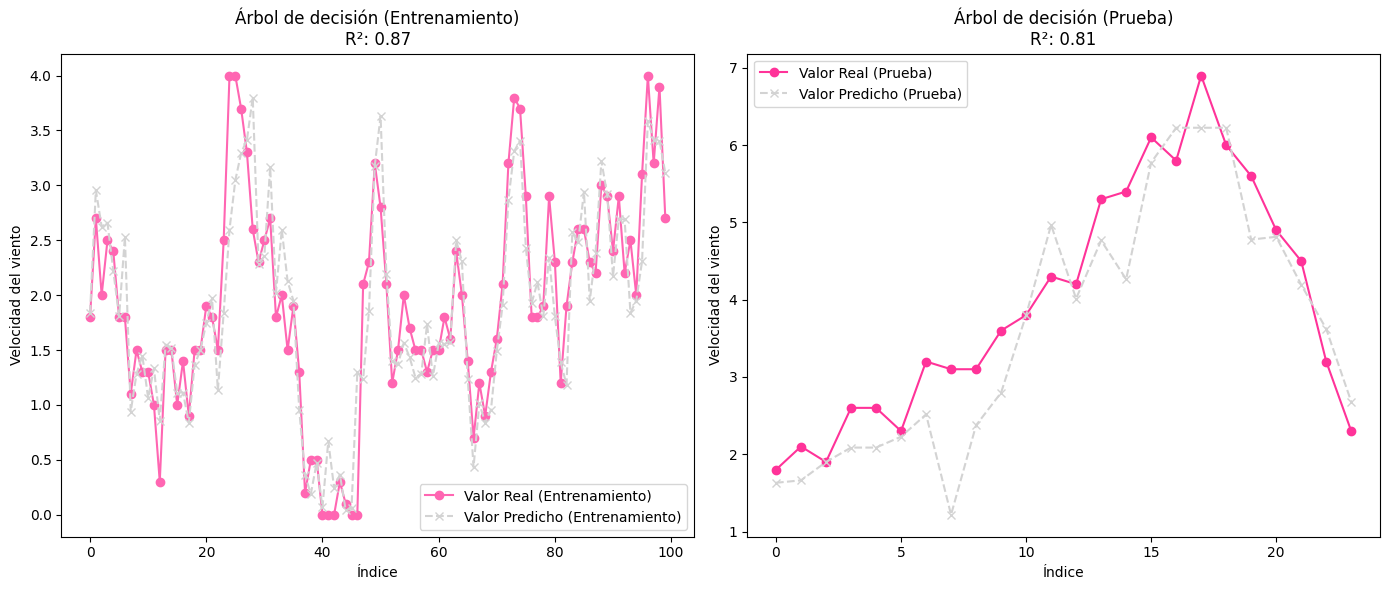

In [ ]:
ypred = dectree.predict(Xp_test)
ypredtrain = dectree.predict(Xp_train)
graph_predictions(y_train, ypredtrain, y_test, ypred, 'Árbol de decisión')


Se obtuvo un excelente score en entrenamiento, del 87%. Hubo una disminución del coeficiente de determinación del 6% en prueba, aún así, se ajustó bastante bien a los valores extremos a diferencia del árbol de decisión con tres base learners. Se notan predicciones muy malas, como en el índice 7 aproximadamene.

### **Hiperparametrización para Random Forest**


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import ParameterGrid

r2_val = []
best_r2 = -float('inf')
best_n_estimators = None
best_max_depth = None
best_min_samples_split = None
best_min_samples_leaf = None
best_max_features = None
best_bootstrap = None
best_rmse = None

# 5400
param_grid = {
    'n_estimators': range(10, 101, 10),
    'max_depth': range(5, 31, 5)
}

for params in ParameterGrid(param_grid):
    print(params)
    n_estimators = params['n_estimators']
    max_depth = params['max_depth']

    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=25
    )

    rf.fit(Xp_train, y_train)
    y_pred = rf.predict(Xp_val)

    r2 = r2_score(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    if r2 > best_r2:
        best_r2 = r2
        best_n_estimators = n_estimators
        best_max_depth = max_depth
        best_min_samples_split = min_samples_split
        best_min_samples_leaf = min_samples_leaf
        best_rmse = rmse

    r2_val.append((n_estimators, max_depth, min_samples_split, min_samples_leaf, r2, rmse))



In [ ]:
print(f"Mejor R²: {best_r2}, Mejor n_estimators: {best_n_estimators}, Mejor max_depth: {best_max_depth} RMSE: {best_rmse}")

Mejor R²: 0.6775478891519091, Mejor n_estimators: 10, Mejor max_depth: 10 RMSE: 0.49853228876142575


In [ ]:
ranfor = RandomForestRegressor(n_estimators= 10,max_depth= 10, random_state=25)

ranfor.fit(Xp_train,y_train)
ypredranfor = ranfor.predict(Xp_test)
ranfor.score(Xp_test, y_test)

0.8112085676225407

In [ ]:
mseranfor = mean_squared_error(y_test, ypredranfor)
rmseranfor = np.sqrt(mseranfor)
maperanfor = MAPE(y_test, ypredranfor)
maeranfor = mean_absolute_error(y_test, ypredranfor)
r2ranfor = r2_score(y_test, ypredranfor)
ljungboxranfor, jarquebreranfor = residuos(y_test, ypredranfor)

In [ ]:
valoresranfor = {'Modelo': ['RANDOM FOREST'],'MSE': [mseranfor],'RMSE': [rmseranfor],'MAPE': [maperanfor],'MAE': [maeranfor],'R2': [r2ranfor],'Ljung-Box p-value': [ljungboxranfor],'Jarque-Bera p-value': [jarquebreranfor]}
cuadro5 = pd.DataFrame(valoresranfor)
cuadro5

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,RANDOM FOREST,0.417216,0.645923,14.062093,0.530821,0.811209,0.258883,0.954305


El modelo **random forest** presenta un **MSE** de 0.417216 y un **RMSE** de 0.645923, lo que indica un error moderado en las predicciones. Con un **R²** de 0.811209, el modelo explica aproximadamente el 81.12% de la variabilidad de los datos, lo que sugiere un buen ajuste. Los **p-valores** de las pruebas de Ljung-Box (0.258883) y Jarque-Bera (0.954305) indican que no hay evidencia significativa de autocorrelación ni de no normalidad en los residuos.

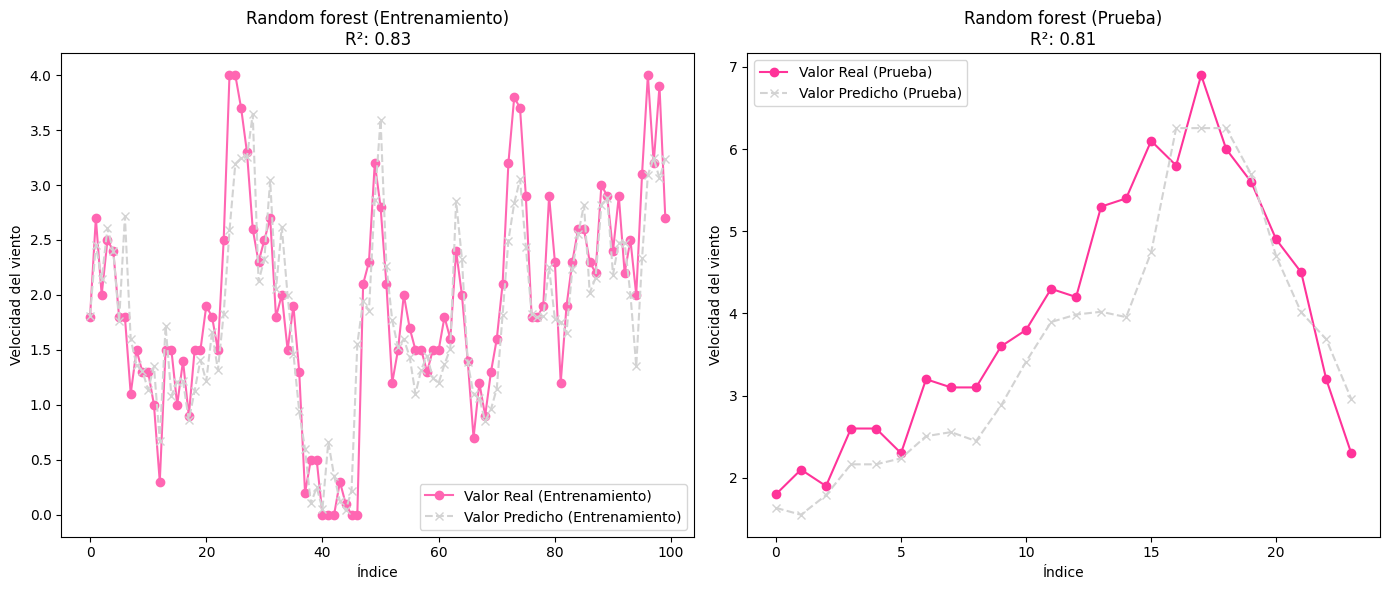

In [ ]:
ypred = ranfor.predict(Xp_test)
ypredtrain = ranfor.predict(Xp_train)
graph_predictions(y_train, ypredtrain, y_test, ypred, 'Random forest')


Se observa un buen ajuste general tanto en entrenamiento con en prueba. Las predicciones asociadas a valores máximos en prueba están bien realizadas.

### **Hiperparametrización para XGBoost**

In [ ]:
r2_val = []
best_r2 = -float('inf')
best_n_estimators = None
best_max_depth = None
best_learning_rate = None
best_subsample = None
best_colsample_bytree = None
best_min_child_weight = None
best_gamma = None

# 9600
param_grid = {
    'n_estimators': range(10, 101, 10),
    'max_depth': range(5, 21),
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

for params in ParameterGrid(param_grid):
    n_estimators = params['n_estimators']
    max_depth = params['max_depth']
    learning_rate = params['learning_rate']
    xgb = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate
    )

    xgb.fit(Xp_train, y_train)
    y_pred = xgb.predict(Xp_val)

    r2 = r2_score(y_val, y_pred)
    if r2 > best_r2:
        best_r2 = r2
        best_n_estimators = n_estimators
        best_max_depth = max_depth
        best_learning_rate = learning_rate

    r2_val.append((n_estimators, max_depth, learning_rate, r2))


In [ ]:
print(f"Best R²: {best_r2}")
print(f"Best n_estimators: {best_n_estimators}, Best max_depth: {best_max_depth}")
print(f"Best learning_rate: {best_learning_rate}")

Best R²: 0.6816921650612373
Best n_estimators: 30, Best max_depth: 9
Best learning_rate: 0.1


In [ ]:
xgboost = XGBRegressor(n_estimators= 30,max_depth= 9, learning_rate = 0.1)

xgboost.fit(Xp_train,y_train)
ypredxgboost = xgboost.predict(Xp_test)
xgboost.score(Xp_test, y_test)

0.8061108705349451

In [ ]:
msexgboost = mean_squared_error(y_test, ypredxgboost)
rmsexgboost = np.sqrt(msexgboost)
mapexgboost = MAPE(y_test, ypredxgboost)
maexgboost = mean_absolute_error(y_test, ypredxgboost)
r2xgboost = r2_score(y_test, ypredxgboost)
ljungboxxgboost, jarquebarexgboost = residuos(y_test, ypredxgboost)

In [ ]:
valoresxgboost = {'Modelo': ['XGBOOST'],'MSE': [msexgboost],'RMSE': [rmsexgboost],'MAPE': [mapexgboost],'MAE': [maexgboost],'R2': [r2xgboost],'Ljung-Box p-value': [ljungboxxgboost],'Jarque-Bera p-value': [jarquebarexgboost]}
cuadro6 = pd.DataFrame(valoresxgboost)
cuadro6

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,XGBOOST,0.428482,0.654585,14.14237,0.538287,0.806111,0.203712,0.975059


El modelo **XGBoost** presenta un **MSE** de 0.428482 y un **RMSE** de 0.654585, lo que indica errores moderados en las predicciones. Con un **R²** de 0.806111, el modelo explica aproximadamente el 80.61% de la variabilidad de los datos, lo que sugiere un buen ajuste. Los **p-valores** de las pruebas de Ljung-Box (0.203712) y Jarque-Bera (0.975059) indican que no hay evidencia significativa de autocorrelación ni de no normalidad en los residuos.

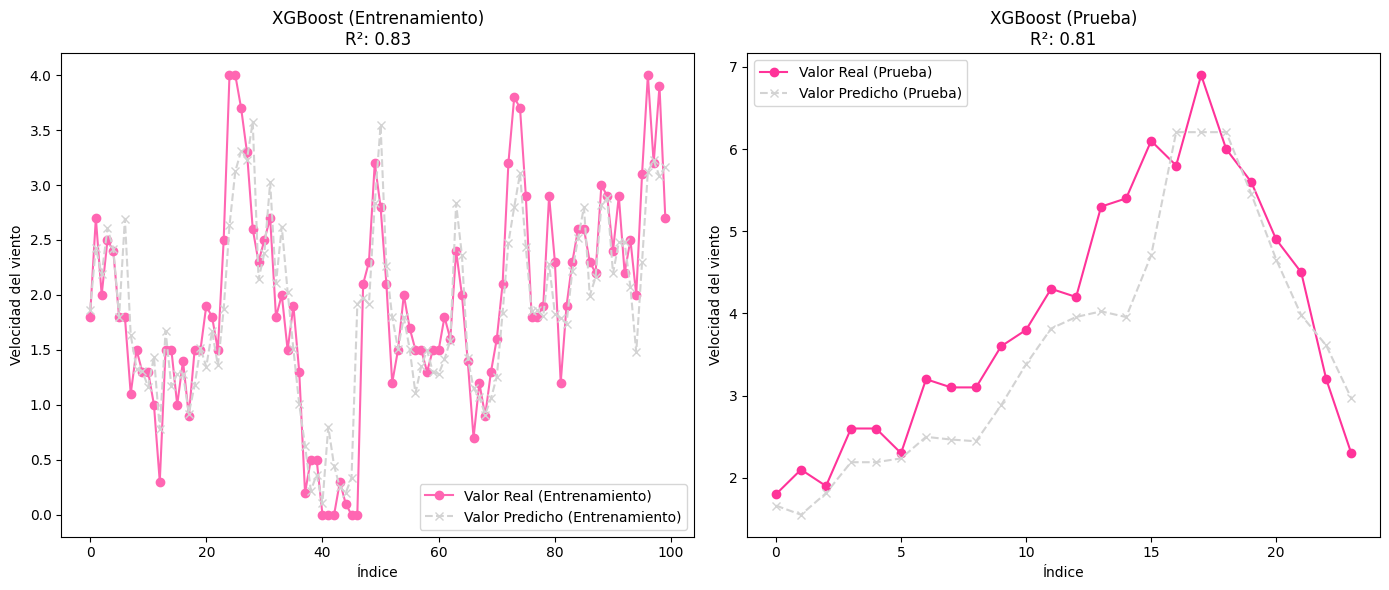

In [ ]:
ypred = xgboost.predict(Xp_test)
ypredtrain = xgboost.predict(Xp_train)
graph_predictions(y_train, ypredtrain, y_test, ypred, 'XGBoost')


Se observa buen ajuste general en el modelo tanto en entrenamiento como en prueba, ya esperado debido a las metricas arrojadas en test. Nuevamente, predice mejor valores altos, peroo aún así parece tener problemas.

### **Hiperparametrización para SVR**

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import numpy as np

r2_val = []
best_r2 = -float('inf')
best_C = None
best_kernel = None
best_gamma = None
best_epsilon = None
best_tol = None
best_degree = None

for C in np.arange(0.01, 1, 0.1):
    for kernel in ["linear", "rbf"]:
        for gamma in ["scale", "auto"]:
                        print(C, kernel, gamma)
                        svr = SVR(C=C, kernel=kernel, gamma=gamma)

                        svr.fit(Xp_train, y_train)

                        y_pred = svr.predict(Xp_val)

                        r2 = r2_score(y_val, y_pred)

                        if r2 > best_r2:
                            best_r2 = r2
                            best_C = C
                            best_kernel = kernel
                            best_gamma = gamma

                        r2_val.append((C, kernel, gamma, r2))


In [ ]:
print(f"Best R²: {best_r2}")
print(f"Best C: {best_C}, Best kernel: {best_kernel}, Best gamma: {best_gamma}")

In [ ]:
svr = SVR(C=0.01, kernel='linear', gamma='scale')

svr.fit(Xp_train,y_train)
ypredsvr = svr.predict(Xp_test)
svr.score(Xp_test, y_test)

0.8190864988915199

In [ ]:
msesvr = mean_squared_error(y_test, ypredsvr)
rmsesvr = np.sqrt(msesvr)
mapesvr =MAPE(y_test,ypredsvr)
maesvr = mean_absolute_error(y_test, ypredsvr)
r2svr = r2_score(y_test, ypredsvr)
ljungboxsvr, jarquebaresvr = residuos(y_test, ypredsvr)

In [ ]:
valoressvr = {'Modelo': ['SVR'],'MSE': [msesvr],'RMSE': [rmsesvr],'MAPE': [mapesvr],'MAE': [maesvr],'R2': [r2svr],'Ljung-Box p-value': [ljungboxsvr],'Jarque-Bera p-value': [jarquebaresvr]}
cuadro7 = pd.DataFrame(valoressvr)
cuadro7

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,SVR,0.399806,0.632302,13.569693,0.512612,0.819086,0.30878,0.940227


El modelo **SVR** presenta un **MSE** de 0.399806 y un **RMSE** de 0.632302, lo que indica un error moderado en las predicciones. Con un **R²** de 0.819086, el modelo explica aproximadamente el 81.91% de la variabilidad de los datos, lo que sugiere un buen ajuste. Los **p-valores** de las pruebas de Ljung-Box (0.30878) y Jarque-Bera (0.940227) indican que no hay evidencia significativa de autocorrelación ni de no normalidad en los residuos.

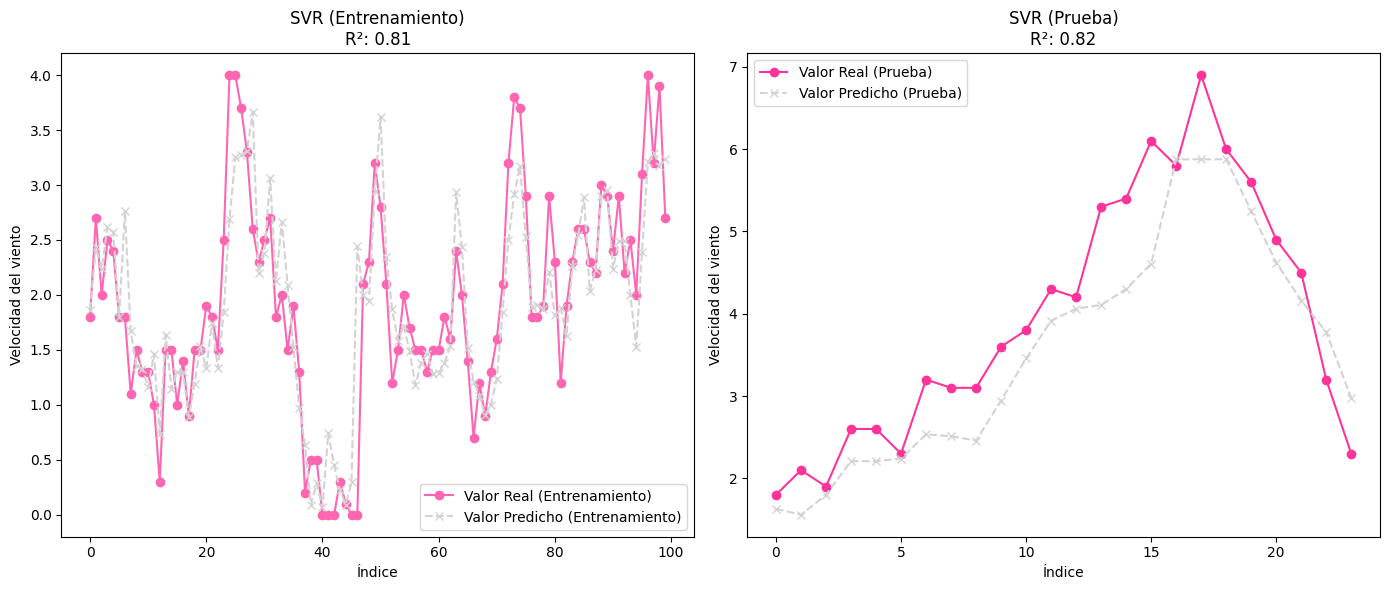

In [ ]:
ypred = svr.predict(Xp_test)
ypredtrain = svr.predict(Xp_train)
graph_predictions(y_train, ypredtrain, y_test, ypred, 'SVR')


Presenta un buen ajuste en ambos conjuntos de datos, ligeramente mejor en prueba. Presenta el mismo inconveniente de la predicción del valor extremo pero es mejor que otros modelos.

### **Resultados generales**

In [ ]:
cuadro9 = [cuadro1, cuadro2, cuadro3, cuadro4, cuadro5, cuadro6, cuadro7, cuadro8]
cuadro9 = pd.concat(cuadro9)
cuadro9 = cuadro9.sort_values(by='R2', ascending=False)
cuadro9

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,KNN,0.335990,0.579647,13.482857,0.488480,0.847963,0.466765,0.605240
0,SVR,0.399806,0.632302,13.569693,0.512612,0.819086,0.308780,0.940227
0,DEC. TREE,0.411925,0.641814,13.792041,0.499719,0.813603,0.400202,0.397399
0,RANDOM FOREST,0.417216,0.645923,14.062093,0.530821,0.811209,0.258883,0.954305
0,XGBOOST,0.428482,0.654585,14.142370,0.538287,0.806111,0.203712,0.975059
0,LASSO,0.436542,0.660713,14.735133,0.549878,0.802463,0.319511,0.929675
0,REG. LINEAL,0.447220,0.668745,14.696839,0.552116,0.797632,0.300747,0.938138
0,RIDGE,0.448381,0.669613,14.718895,0.552965,0.797106,0.299967,0.937912


Los modelos evaluados corresponden a **meta learners** con cuatro **base learners** y presentan un desempeño variado en términos de precisión, ajuste y comportamiento de los residuos.

El modelo **KNN** tiene un **MSE** de 0.335990 y un **RMSE** de 0.579647, indicando un buen ajuste general, con un **R²** alto de 0.847963. Aunque el **MAPE** es de 13.48%, la prueba de **Jarque-Bera** (0.605240) sugiere que los residuos siguen una distribución cercana a la normal. Este modelo muestra un buen equilibrio entre precisión y estabilidad de residuos.

Por su parte, **SVR** tiene un **MSE** de 0.399806 y un **RMSE** de 0.632302, lo que indica una ligera mayor imprecisión comparado con **KNN**. Su **R²** de 0.819086 es aún alto, y las pruebas de residuos (**Ljung-Box** y **Jarque-Bera**) muestran que no hay autocorrelación ni problemas de normalidad en los residuos, lo que refuerza la estabilidad del modelo.

El modelo **Decision tree** tiene un **MSE** de 0.411925, un **RMSE** de 0.641814 y un **R²** de 0.813603. Aunque sus resultados son buenos, su desempeño es ligeramente inferior en comparación con **KNN** y **SVR**. Sin embargo, las pruebas estadísticas sugieren estabilidad en los residuos, sin evidencias significativas de autocorrelación ni no-normalidad.

**Random Forest** presenta un **MSE** de 0.417216 y un **RMSE** de 0.645923. Su **R²** es de 0.811209, lo que indica una capacidad moderada para capturar la variabilidad de los datos. A pesar de tener un desempeño similar al de **Decision tree**, **random forest** muestra mejores resultados en términos de las pruebas de residuos, con un p-valor alto en **Jarque-Bera** (0.954305), lo que sugiere normalidad en los residuos.

**XGBoost**, con un **MSE** de 0.428482 y un **RMSE** de 0.654585, tiene un **R²** de 0.806111, lo que lo hace adecuado, aunque ligeramente inferior a los modelos anteriores. Las pruebas de residuos indican que no hay autocorrelación ni problemas de normalidad, pero sus resultados son menos robustos en comparación con otros modelos.

En cuanto a los modelos lineales, **lasso**, **regresión lineal** y **ridge** tienen un **MSE** y **RMSE** más altos en comparación con los modelos no lineales. **LAsso** tiene un **R²** de 0.802463, **Regresión lineal** de 0.797632, y **Ridge** de 0.797106, lo que indica que estos modelos tienen un ajuste razonable pero menor capacidad predictiva que los modelos no lineales. Sin embargo, sus pruebas de residuos (**Jarque-Bera**) también muestran estabilidad.

En resumen, los modelos no lineales (**KNN**, **SVR**, **Decision Tree**, **Random Forest**, **XGBoost**) tienden a ofrecer un mejor desempeño en términos de ajuste y precisión, mientras que los modelos lineales (**Lasso**, **Regresión Lineal**, **Ridge**) tienen un ajuste algo más limitado, a pesar de ser tres de los cuatro base learners utilizados, pero presentan residuos estables.

In [ ]:
stacking_4bl = cuadro9

## **Comparación de base learners y meta learners con 4 y 3 base learners**

In [ ]:
modelosbases['Base learners'] = 'No aplica'

In [ ]:
modelosbases

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value,Base learners
0,REG. LINEAL,0.358341,0.598616,15.739528,0.541310,0.837850,0.192736,0.095363,No aplica
0,RIDGE,0.358581,0.598816,15.746817,0.541537,0.837741,0.192629,0.095406,No aplica
0,SVR,0.362467,0.602052,15.125073,0.508772,0.835983,0.015236,0.148630,No aplica
0,LASSO,0.468375,0.684379,15.627265,0.586556,0.788059,0.284742,0.050258,No aplica
0,XGBOOST,0.471152,0.686405,14.995415,0.572242,0.786802,0.236152,0.910029,No aplica
0,RANDOM FOREST,0.517051,0.719063,16.628608,0.621354,0.766033,0.344430,0.697858,No aplica
0,DEC. TREE,0.600514,0.774928,17.311127,0.619180,0.728266,0.692234,0.204984,No aplica
0,KNN,0.996620,0.998308,21.163538,0.863542,0.549027,0.074711,0.380957,No aplica


In [ ]:
stacking_4bl['Base learners'] = '4'

In [ ]:
stacking_4bl

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value,Base learners
0,KNN,0.335990,0.579647,13.482857,0.488480,0.847963,0.466765,0.605240,4
0,SVR,0.399806,0.632302,13.569693,0.512612,0.819086,0.308780,0.940227,4
0,DEC. TREE,0.411925,0.641814,13.792041,0.499719,0.813603,0.400202,0.397399,4
0,RANDOM FOREST,0.417216,0.645923,14.062093,0.530821,0.811209,0.258883,0.954305,4
0,XGBOOST,0.428482,0.654585,14.142370,0.538287,0.806111,0.203712,0.975059,4
0,LASSO,0.436542,0.660713,14.735133,0.549878,0.802463,0.319511,0.929675,4
0,REG. LINEAL,0.447220,0.668745,14.696839,0.552116,0.797632,0.300747,0.938138,4
0,RIDGE,0.448381,0.669613,14.718895,0.552965,0.797106,0.299967,0.937912,4


In [ ]:
stacking_3bl['Base learners'] = "3"

In [ ]:
stacking_3bl

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value,Base learners
0,SVR,0.323547,0.568812,14.558665,0.501322,0.853594,0.124485,0.098749,3
0,RIDGE,0.358260,0.598549,15.737396,0.541237,0.837886,0.192711,0.095328,3
0,REG. LINEAL,0.358341,0.598616,15.739528,0.541310,0.837850,0.192736,0.095363,3
0,LASSO,0.359584,0.599653,15.701460,0.541523,0.837287,0.219253,0.092174,3
0,XGBOOST,0.529450,0.727633,16.132808,0.573133,0.760422,0.751574,0.282879,3
0,KNN,0.536753,0.732634,16.370041,0.607353,0.757118,0.104821,0.208181,3
0,RANDOM FOREST,0.591450,0.769058,17.172687,0.652494,0.732367,0.056950,0.055058,3
0,DEC. TREE,0.731780,0.855441,17.899770,0.685697,0.668867,0.002836,0.489894,3


In [ ]:
resultados_finales = pd.concat([modelosbases, stacking_4bl, stacking_3bl])

In [ ]:
resultados_finales = resultados_finales.sort_values(by='RMSE', ascending=True)
resultados_finales

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value,Base learners
0,SVR,0.323547,0.568812,14.558665,0.501322,0.853594,0.124485,0.098749,3
0,KNN,0.335990,0.579647,13.482857,0.488480,0.847963,0.466765,0.605240,4
0,RIDGE,0.358260,0.598549,15.737396,0.541237,0.837886,0.192711,0.095328,3
0,REG. LINEAL,0.358341,0.598616,15.739528,0.541310,0.837850,0.192736,0.095363,No aplica
0,REG. LINEAL,0.358341,0.598616,15.739528,0.541310,0.837850,0.192736,0.095363,3
0,RIDGE,0.358581,0.598816,15.746817,0.541537,0.837741,0.192629,0.095406,No aplica
0,LASSO,0.359584,0.599653,15.701460,0.541523,0.837287,0.219253,0.092174,3
0,SVR,0.362467,0.602052,15.125073,0.508772,0.835983,0.015236,0.148630,No aplica
0,SVR,0.399806,0.632302,13.569693,0.512612,0.819086,0.308780,0.940227,4
0,DEC. TREE,0.411925,0.641814,13.792041,0.499719,0.813603,0.400202,0.397399,4


Estos representan los 24 modelos realizados, incluyendo los modelos bases (sin utilizar metalearners) y los modelos que utilizan stacking con 3 y 4 base learners. Se observa que los tres modelos obtenidos para la predicción del viento corresponden a modelos ensamblados utilizando, en primer lugar, 3 base learners con un SVR como metalearner, en segundo lugar KNN como metalerner utilizando cuatro base learners y en tercer lugar ridge con 3 base learners.

Se aprecian también que no hubo una mejoría entre regresión lineal base o utilizándola como metalearner que utilizándolo con tres base learners, a diferencia de otros base learners involucrados usados como metalearners como es el caso de Ridge, Lasoo y XGBoost.

```{note}
Dado los resultados obtenidos, se elige SVR como metalearner con 3 base learners como el modelo propuesto que mejora la predicción del viento horaria, es decir, el flujo general trabajado durante este proyecto culmina de la siguiente manera:
```


![](assets/finalml.png)

In [ ]:
resultados_finales.iloc[[0, 3, 5, 15]]

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value,Base learners
0,SVR,0.323547,0.568812,14.558665,0.501322,0.853594,0.124485,0.098749,3
0,REG. LINEAL,0.358341,0.598616,15.739528,0.541310,0.837850,0.192736,0.095363,No aplica
0,RIDGE,0.358581,0.598816,15.746817,0.541537,0.837741,0.192629,0.095406,No aplica
0,LASSO,0.468375,0.684379,15.627265,0.586556,0.788059,0.284742,0.050258,No aplica


El modelo **SVR** como metalearner utilizando los base learners mostrados en la tabla, muestra un rendimiento superior en comparación con los modelos base learners (**Regresión lineal**, **Ridge**, **Lasso**) en términos de **MSE**, **RMSE** y **MAPE**. Con un **MSE** de 0.323547 y un **RMSE** de 0.568812, **SVR** presenta menores errores en las predicciones en comparación con los modelos lineales, cuyos valores de **MSE** y **RMSE** son más altos (0.358341 y 0.358581 para **REG. LINEAL** y **RIDGE**, respectivamente). En cuanto al **MAPE**, **SVR** también supera a los modelos base con un 14.56%, mientras que **Regresión lineal**, **Ridge** y **Lasso** tienen valores superiores (15.74%, 15.75% y 15.63%, respectivamente). Esto sugiere que **SVR** es más preciso y consistente en sus predicciones en comparación con los modelos lineales, que presentan un ajuste ligeramente peor. Sin embargo, **Lasso** es el que muestra el peor desempeño, con los valores más altos en **MSE**, **RMSE** y **MAPE**.

En este caso, el **SVR** ha mostrado un mejor desempeño general que los base learners en términos de **MSE**, **RMSE**, y **MAPE**, lo cual sugiere que el ensamblaje con **stacking** ha mejorado la capacidad predictiva al combinar de manera efectiva los distintos enfoques de los modelos base. Es decir, el ensamblaje con **stacking** funcionó, ya que **SVR** como meta-learner ha superado a los modelos base, lo que indica que la técnica logró optimizar el rendimiento general del modelo.

In [ ]:
ypredtrain = svr.predict(Xp_train)
ypred = svr.predict(Xp_test)
y_pred = svr.predict(Xp_val)

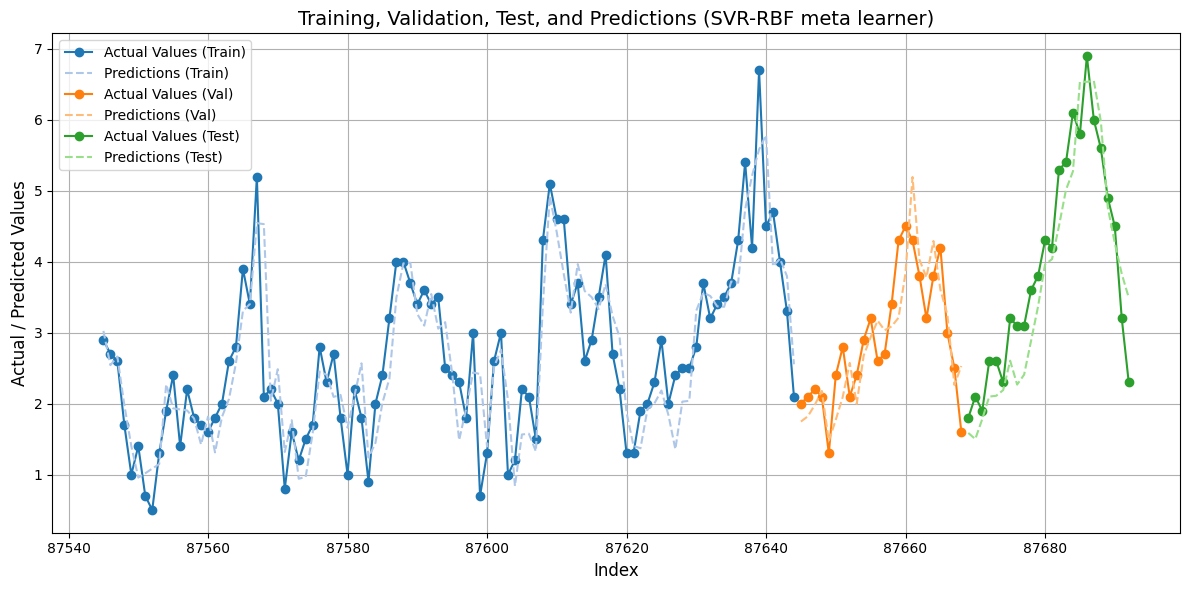

In [ ]:
train_indices = np.arange(len(y_train) - 100, len(y_train))
y_train_subset = y_train[-100:]
ypredtrain = ypredtrain[-100:]
val_indices = np.arange(len(y_train), len(y_train) + len(y_val))
test_indices = np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test))

plt.figure(figsize=(12, 6))

plt.plot(train_indices, y_train_subset, label="Actual Values (Train)", marker='o', color='#1f77b4')
plt.plot(train_indices, ypredtrain, label="Predictions (Train)", linestyle='--', color='#aec7e8')

plt.plot(val_indices, y_val, label="Actual Values (Val)", marker='o', color='#ff7f0e')
plt.plot(val_indices, y_pred, label="Predictions (Val)", linestyle='--', color='#ffbb78')

plt.plot(test_indices, y_test, label="Actual Values (Test)", marker='o', color='#2ca02c')
plt.plot(test_indices, ypred, label="Predictions (Test)", linestyle='--', color='#98df8a')

plt.title("Training, Validation, Test, and Predictions (SVR-RBF meta learner)", fontsize=14)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Actual / Predicted Values", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

Es decir, la predicción de nuevos datos está dada por:

In [1]:
def predict_og(sample):
  samplelasso = modelolasso.predict(sample)
  samplelridge = modeloridge.predict(sample)
  samplellineal = modelolineal.predict(sample)
  sample_set = pd.DataFrame([samplelasso, samplelridge, samplellineal]).T
  sample = sample_set.rename(columns = {0:'lasso',1:'ridge',2:'lineal'})
  final_value = svr.predict(sample)
  return final_value